# ARIMA
Here, seasonality can again be used. Regular ARIMA model will predcit a single point forecast for the entire horizon, however seasonal ARIMA (SARIMA) can accommodate the seasonal pattern.<br><br>
SARIMA model is implemented in this notebook. In order to make the series stationary, seasonal and trend adjustments might be needed.<br>
To determine the right order of seasonal and non-seasonal AR/MA components, <i>auto_arima</i> is used.
>NOTE: This notebook does not combine SARIMA with other exogenous variables.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error, mean_squared_error

### Stationarity
A series should have stable mean, variance and ACF structure (that are not time varying).<br>
While seasonality can be adjusted via harmonics, it would make this model a dynamic regression model which is not covered here.
<br><br>
- For the load data (Zone 1) covered in exploratory data analysis, ACF and PACFs may or may not have been reliable since we didn't check for stationarity.
- It's better to perform ADF test that also account for a linear trend, since regression model also included the trend term.

In [2]:
# Loading the data
import pandas as pd
load_long = pd.read_csv(r"C:\Users\singh\Desktop\TUD (All Semesters)\Courses - Semester 6 (TU Dresden)\Thesis Work\Exploratory Code\load_history_long.csv").sort_values(by = "timestamp")

# Filtering for Zone 1, applying log transformation on load (after rescaling)
import numpy as np

load_long_z1 = load_long
load_long_z1["load_rs"] = load_long_z1.load / 1000
load_long_z1["log_load_rs"] = np.log(load_long_z1.load_rs)
load_long_z1 = load_long_z1.loc[load_long_z1.zone_id == 1,:].sort_values(by = "timestamp").reset_index(drop=True)
load_long_z1.head()

C:\Users\singh\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,zone_id,year,month,day,hour,load,timestamp,load_rs,log_load_rs
0,1,2004,1,1,00:30,16853.0,2004-01-01 00:30:00,16.853,2.824529
1,1,2004,1,1,01:30,16450.0,2004-01-01 01:30:00,16.450,2.800325
2,1,2004,1,1,02:30,16517.0,2004-01-01 02:30:00,16.517,2.804390
3,1,2004,1,1,03:30,16873.0,2004-01-01 03:30:00,16.873,2.825715
4,1,2004,1,1,04:30,17064.0,2004-01-01 04:30:00,17.064,2.836971


Variance stabilisation is already done by rescaling the data and applying <b>log transformation</b> to the load values.<br>
The transformed values are represented by <i>log_load_rs</i> column.

In [3]:
# Defining a function to check if a series is stationary

def check_stationarity(timeseries):
    result = adfuller(timeseries, autolag='AIC')
    p_value = result[1]
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {p_value}')
    print('Stationary' if p_value < 0.05 else 'Non-Stationary')

### PACF (adjusts for lags 'in-between'): Applied on Variance Stabilised Load
To understand about whether to use AR or MA, ACF should be studied along with PACF. <br>
AR processes assume that significance of past shocks decays exponentially, which may or may not be the case. <br>
MA processes seem to abruptly cut-off in significance after a certain past shock.

#### Zone 1 - 2004

Text(0, 0.5, 'PACF')

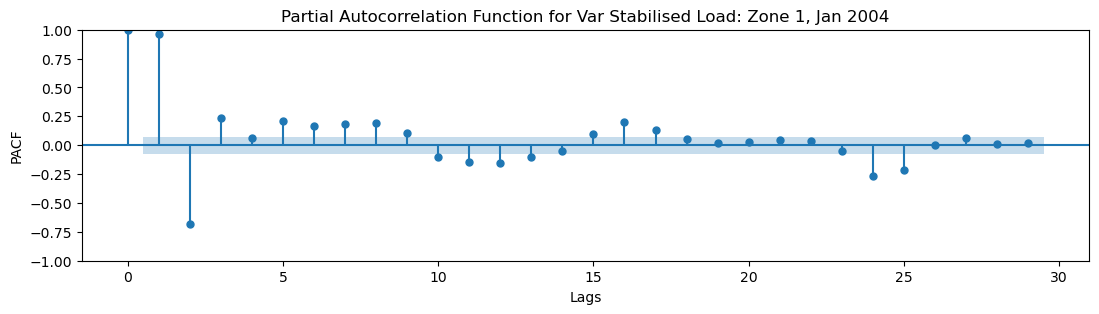

In [4]:
# Observing the PACF plot - Only for zone 1 (2004); subsetting the data for Jan 2004
from statsmodels.graphics.tsaplots import plot_pacf

fig, ax = plt.subplots(figsize=(13,3))
plot_pacf(load_long_z1.sort_values(by="timestamp").loc[(load_long_z1["year"]==2004)&(load_long_z1["month"]==1),"log_load_rs"],
         ax=ax)

ax.set_title("Partial Autocorrelation Function for Var Stabilised Load: Zone 1, Jan 2004")
ax.set_xlabel("Lags")
ax.set_ylabel("PACF")

In [5]:
# Checking for stationarity
check_stationarity(load_long_z1.sort_values(by="timestamp").loc[(load_long_z1["year"]==2004)&(load_long_z1["month"]==1),"log_load_rs"].reset_index(drop=True))

ADF Statistic: -2.355350866284956
p-value: 0.15473670712253706
Non-Stationary


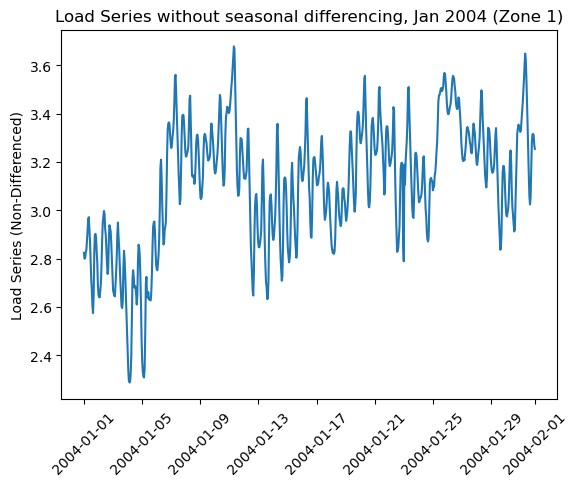

In [6]:
# Load series: non-stationary, Jan 2004 (Zone 1)

import seaborn as sns
fig, ax = plt.subplots()
sns.lineplot(x=pd.to_datetime(load_long_z1.sort_values(by="timestamp").loc[(load_long_z1["year"]==2004)&(load_long_z1["month"]==1),"timestamp"].reset_index(drop=True)), y=load_long_z1.sort_values(by="timestamp").loc[(load_long_z1["year"]==2004)&(load_long_z1["month"]==1),"log_load_rs"].reset_index(drop=True))
plt.ylabel("Load Series (Non-Differenced)")
plt.xlabel("")
ax.set_title("Load Series without seasonal differencing, Jan 2004 (Zone 1)")
plt.xticks(rotation=45)
plt.show()

Text(0, 0.5, 'PACF')

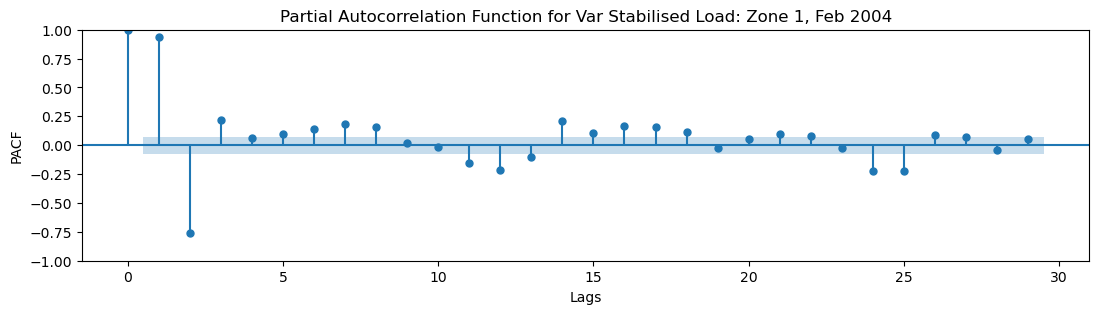

In [7]:
# Observing the PACF plot - Only for zone 1 (2004); subsetting the data for Feb 2004
from statsmodels.graphics.tsaplots import plot_pacf

fig, ax = plt.subplots(figsize=(13,3))
plot_pacf(load_long_z1.sort_values(by="timestamp").loc[(load_long_z1["year"]==2004)&(load_long_z1["month"]==2),"log_load_rs"],
         ax=ax)

ax.set_title("Partial Autocorrelation Function for Var Stabilised Load: Zone 1, Feb 2004")
ax.set_xlabel("Lags")
ax.set_ylabel("PACF")

In [8]:
# Checking for stationarity
check_stationarity(load_long_z1.sort_values(by="timestamp").loc[(load_long_z1["year"]==2004)&(load_long_z1["month"]==2),"log_load_rs"].reset_index(drop=True))

ADF Statistic: -1.9152684139815184
p-value: 0.3249128081953644
Non-Stationary


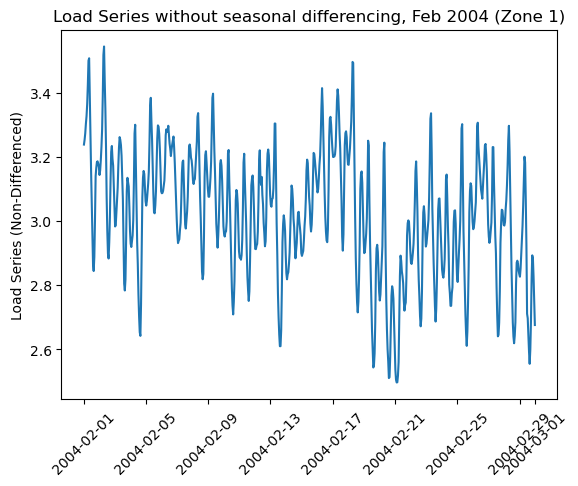

In [9]:
# Load series: non-stationary, Feb 2004 (Zone 1)

import seaborn as sns
fig, ax = plt.subplots()
sns.lineplot(x=pd.to_datetime(load_long_z1.sort_values(by="timestamp").loc[(load_long_z1["year"]==2004)&(load_long_z1["month"]==2),"timestamp"].reset_index(drop=True)), y=load_long_z1.sort_values(by="timestamp").loc[(load_long_z1["year"]==2004)&(load_long_z1["month"]==2),"log_load_rs"].reset_index(drop=True))
plt.ylabel("Load Series (Non-Differenced)")
plt.xlabel("")
ax.set_title("Load Series without seasonal differencing, Feb 2004 (Zone 1)")
plt.xticks(rotation=45)
plt.show()

Text(0, 0.5, 'PACF')

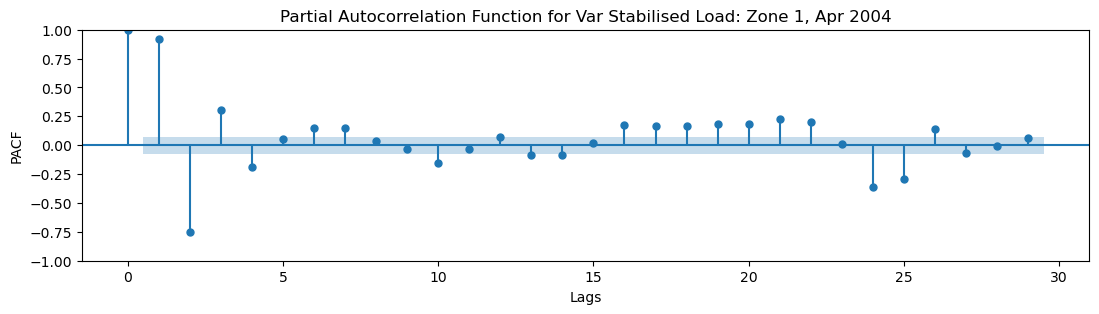

In [10]:
# Observing the PACF plot - Only for zone 1 (2004); subsetting the data for Apr 2004
from statsmodels.graphics.tsaplots import plot_pacf

fig, ax = plt.subplots(figsize=(13,3))
plot_pacf(load_long_z1.sort_values(by="timestamp").loc[(load_long_z1["year"]==2004)&(load_long_z1["month"]==4),"log_load_rs"],
         ax=ax)

ax.set_title("Partial Autocorrelation Function for Var Stabilised Load: Zone 1, Apr 2004")
ax.set_xlabel("Lags")
ax.set_ylabel("PACF")

In [11]:
# Checking for stationarity
check_stationarity(load_long_z1.sort_values(by="timestamp").loc[(load_long_z1["year"]==2004)&(load_long_z1["month"]==4),"log_load_rs"].reset_index(drop=True))

ADF Statistic: -1.5510207172265307
p-value: 0.5081382947521746
Non-Stationary


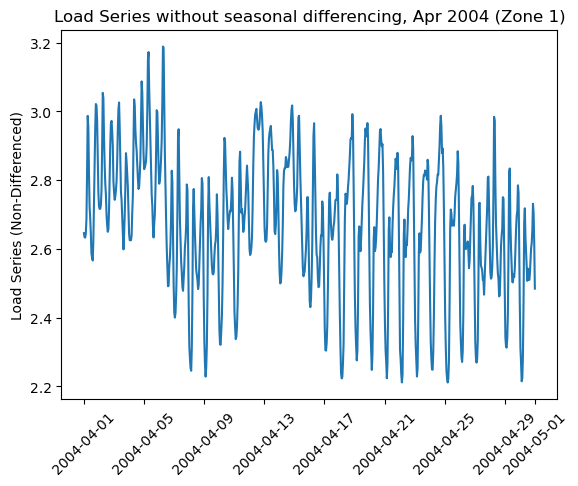

In [12]:
# Load series: non-stationary, Apr 2004 (Zone 1)

import seaborn as sns
fig, ax = plt.subplots()
sns.lineplot(x=pd.to_datetime(load_long_z1.sort_values(by="timestamp").loc[(load_long_z1["year"]==2004)&(load_long_z1["month"]==4),"timestamp"].reset_index(drop=True)), y=load_long_z1.sort_values(by="timestamp").loc[(load_long_z1["year"]==2004)&(load_long_z1["month"]==4),"log_load_rs"].reset_index(drop=True))
plt.ylabel("Load Series (Non-Differenced)")
plt.xlabel("")
ax.set_title("Load Series without seasonal differencing, Apr 2004 (Zone 1)")
plt.xticks(rotation=45)
plt.show()

Text(0, 0.5, 'PACF')

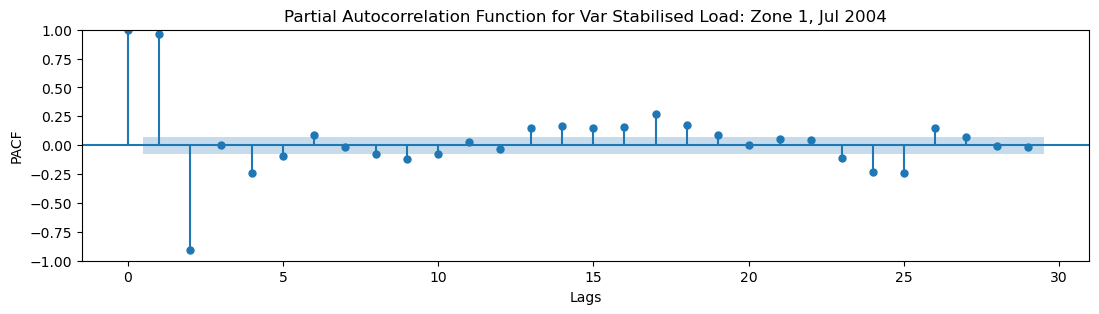

In [13]:
# Observing the PACF plot - Only for zone 1 (2004); subsetting the data for Jul 2004
from statsmodels.graphics.tsaplots import plot_pacf

fig, ax = plt.subplots(figsize=(13,3))
plot_pacf(load_long_z1.sort_values(by="timestamp").loc[(load_long_z1["year"]==2004)&(load_long_z1["month"]==7),"log_load_rs"],
         ax=ax)

ax.set_title("Partial Autocorrelation Function for Var Stabilised Load: Zone 1, Jul 2004")
ax.set_xlabel("Lags")
ax.set_ylabel("PACF")

In [14]:
# Checking for stationarity
check_stationarity(load_long_z1.sort_values(by="timestamp").loc[(load_long_z1["year"]==2004)&(load_long_z1["month"]==7),"log_load_rs"].reset_index(drop=True))

ADF Statistic: -1.800903235526996
p-value: 0.3800133545354716
Non-Stationary


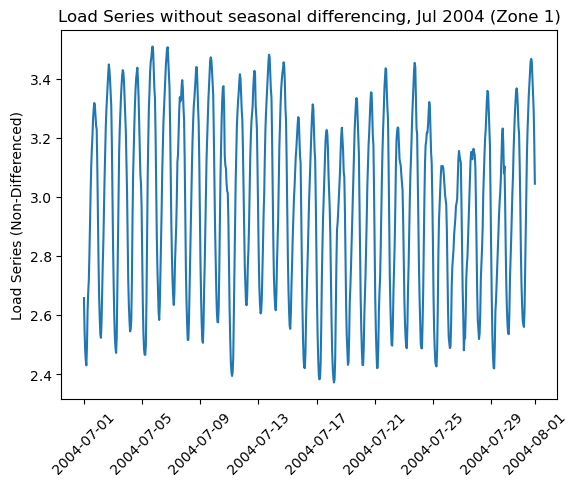

In [15]:
# Load series: non-stationary, Jul 2004 (Zone 1)

import seaborn as sns
fig, ax = plt.subplots()
sns.lineplot(x=pd.to_datetime(load_long_z1.sort_values(by="timestamp").loc[(load_long_z1["year"]==2004)&(load_long_z1["month"]==7),"timestamp"].reset_index(drop=True)), y=load_long_z1.sort_values(by="timestamp").loc[(load_long_z1["year"]==2004)&(load_long_z1["month"]==7),"log_load_rs"].reset_index(drop=True))
plt.ylabel("Load Series (Non-Differenced)")
plt.xlabel("")
ax.set_title("Load Series without seasonal differencing, Jul 2004 (Zone 1)")
plt.xticks(rotation=45)
plt.show()

Text(0, 0.5, 'PACF')

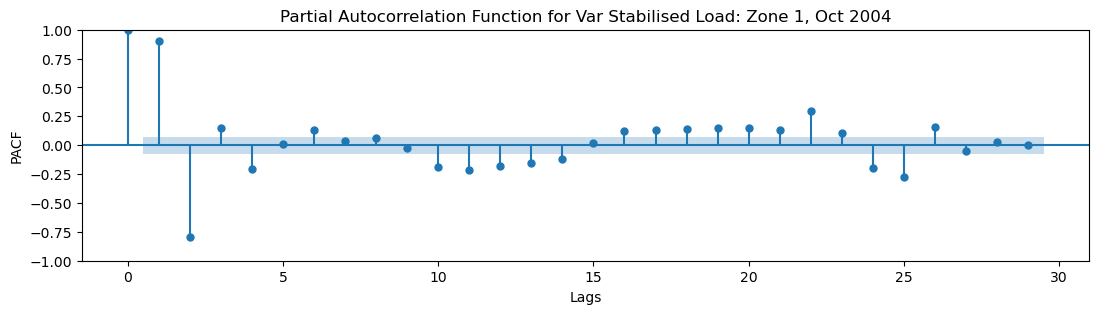

In [16]:
# Observing the PACF plot - Only for zone 1 (2004); subsetting the data for Oct 2004
from statsmodels.graphics.tsaplots import plot_pacf

fig, ax = plt.subplots(figsize=(13,3))
plot_pacf(load_long_z1.sort_values(by="timestamp").loc[(load_long_z1["year"]==2004)&(load_long_z1["month"]==10),"log_load_rs"],
         ax=ax)

ax.set_title("Partial Autocorrelation Function for Var Stabilised Load: Zone 1, Oct 2004")
ax.set_xlabel("Lags")
ax.set_ylabel("PACF")

In [17]:
# Checking for stationarity
check_stationarity(load_long_z1.sort_values(by="timestamp").loc[(load_long_z1["year"]==2004)&(load_long_z1["month"]==10),"log_load_rs"].reset_index(drop=True))

ADF Statistic: -3.251852803029493
p-value: 0.017172704273788007
Stationary


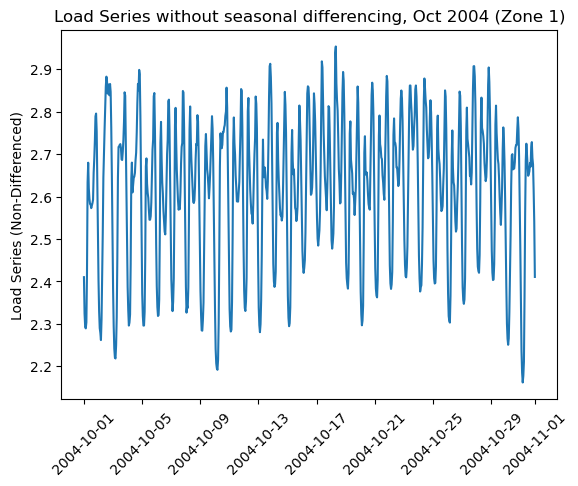

In [18]:
# Load series: non-stationary, Oct 2004 (Zone 1)

import seaborn as sns
fig, ax = plt.subplots()
sns.lineplot(x=pd.to_datetime(load_long_z1.sort_values(by="timestamp").loc[(load_long_z1["year"]==2004)&(load_long_z1["month"]==10),"timestamp"].reset_index(drop=True)), y=load_long_z1.sort_values(by="timestamp").loc[(load_long_z1["year"]==2004)&(load_long_z1["month"]==10),"log_load_rs"].reset_index(drop=True))
plt.ylabel("Load Series (Non-Differenced)")
plt.xlabel("")
ax.set_title("Load Series without seasonal differencing, Oct 2004 (Zone 1)")
plt.xticks(rotation=45)
plt.show()

Text(0, 0.5, 'PACF')

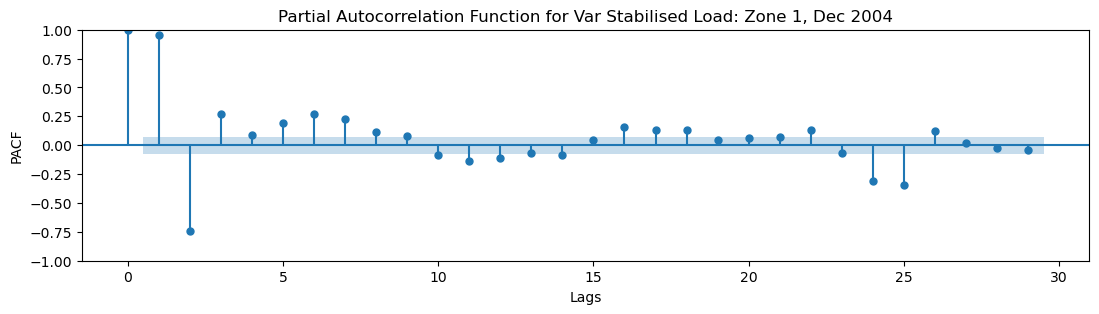

In [19]:
# Observing the PACF plot - Only for zone 1 (2004); subsetting the data for Dec 2004
from statsmodels.graphics.tsaplots import plot_pacf

fig, ax = plt.subplots(figsize=(13,3))
plot_pacf(load_long_z1.sort_values(by="timestamp").loc[(load_long_z1["year"]==2004)&(load_long_z1["month"]==12),"log_load_rs"],
         ax=ax)

ax.set_title("Partial Autocorrelation Function for Var Stabilised Load: Zone 1, Dec 2004")
ax.set_xlabel("Lags")
ax.set_ylabel("PACF")

In [20]:
# Checking for stationarity
check_stationarity(load_long_z1.sort_values(by="timestamp").loc[(load_long_z1["year"]==2004)&(load_long_z1["month"]==12),"log_load_rs"].reset_index(drop=True))

ADF Statistic: -1.7907370332705024
p-value: 0.3850701001895756
Non-Stationary


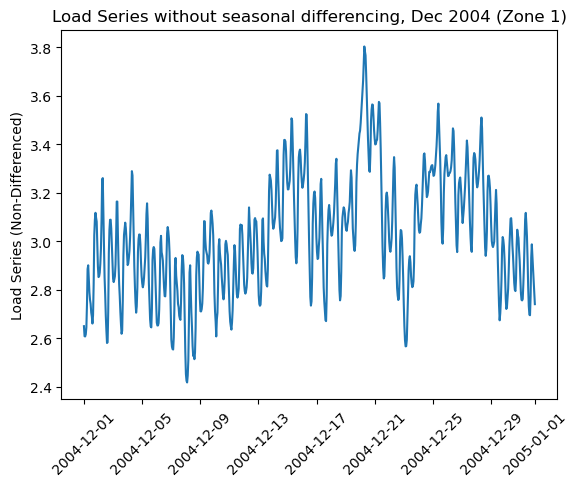

In [21]:
# Load series: non-stationary, Dec 2004 (Zone 1)

import seaborn as sns
fig, ax = plt.subplots()
sns.lineplot(x=pd.to_datetime(load_long_z1.sort_values(by="timestamp").loc[(load_long_z1["year"]==2004)&(load_long_z1["month"]==12),"timestamp"].reset_index(drop=True)), y=load_long_z1.sort_values(by="timestamp").loc[(load_long_z1["year"]==2004)&(load_long_z1["month"]==12),"log_load_rs"].reset_index(drop=True))
plt.ylabel("Load Series (Non-Differenced)")
plt.xlabel("")
ax.set_title("Load Series without seasonal differencing, Dec 2004 (Zone 1)")
plt.xticks(rotation=45)
plt.show()

No cut-off in either ACF or PACF (sinusoidal pattern in both cases). -> This indicates presence of ARMA(p,q)<br>
Note that ACFs and PACFs are plotted on non-stationary data just to get an idea of the series.<br>
To get true underlying structure for the data, we need to have both ACF and PACF on a stationary series.

#### Differencing
Trend and Seasonal adjustments to generate stationary series. Stationarity is essential to get the right underlying structure of the series and determine the order of MA and AR processes.

##### Seasonal Differencing

In [22]:
load_long_z1.head()

,zone_id,year,month,day,hour,load,timestamp,load_rs,log_load_rs
0,1,2004,1,1,00:30,16853.0,2004-01-01 00:30:00,16.853,2.824529
1,1,2004,1,1,01:30,16450.0,2004-01-01 01:30:00,16.450,2.800325
2,1,2004,1,1,02:30,16517.0,2004-01-01 02:30:00,16.517,2.804390
3,1,2004,1,1,03:30,16873.0,2004-01-01 03:30:00,16.873,2.825715
4,1,2004,1,1,04:30,17064.0,2004-01-01 04:30:00,17.064,2.836971


###### Jan 2004

In [23]:
# Seasonal differencing with 24th lag - Only for zone 1 (2004); subsetting the data for Jan 2004

load_long_z1_jan04 = load_long_z1.sort_values(by="timestamp").loc[(load_long_z1["zone_id"]==1)&(load_long_z1["year"]==2004)&(load_long_z1["month"]==1),['zone_id','year','month','day','hour','load','timestamp','load_rs','log_load_rs']]
s_differenced_jan04 = load_long_z1_jan04.sort_values(by="timestamp").loc[:, "log_load_rs"].diff(24)
load_long_z1_jan04['load_seasonally_differenced'] = s_differenced_jan04

# checking for stationarity after adjusting for seasonality and dropping missing values
check_stationarity(load_long_z1_jan04.dropna().reset_index(drop=True).load_seasonally_differenced)

ADF Statistic: -4.695882219779818
p-value: 8.566449007646136e-05
Stationary


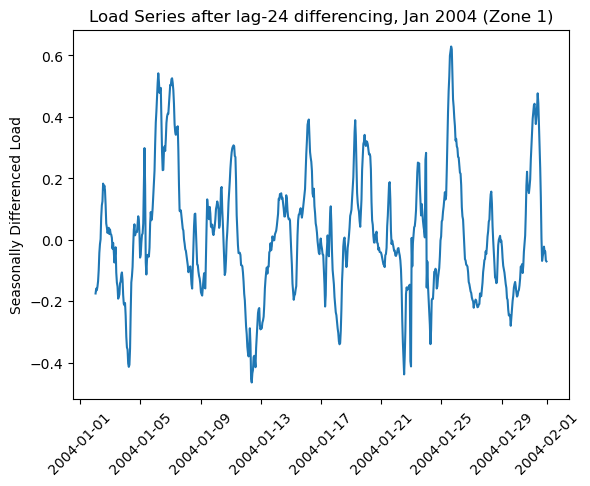

In [24]:
# Load values appear to have no trend, variance is generally even around avg level

import seaborn as sns
fig, ax = plt.subplots()
sns.lineplot(x=pd.to_datetime(load_long_z1_jan04.dropna().reset_index(drop=True).timestamp), y=load_long_z1_jan04.dropna().reset_index(drop=True).load_seasonally_differenced)
plt.ylabel("Seasonally Differenced Load")
plt.xlabel("")
ax.set_title("Load Series after lag-24 differencing, Jan 2004 (Zone 1)")
plt.xticks(rotation=45)
plt.show()

###### Feb 2004

In [25]:
# Seasonal differencing with 24th lag - Only for zone 1 (2004); subsetting the data for Feb 2004

load_long_z1_feb04 = load_long_z1.sort_values(by="timestamp").loc[(load_long_z1["zone_id"]==1)&(load_long_z1["year"]==2004)&(load_long_z1["month"]==2),['zone_id','year','month','day','hour','load','timestamp','load_rs','log_load_rs']]
s_differenced_feb04 = load_long_z1_feb04.sort_values(by="timestamp").loc[:, "log_load_rs"].diff(24)
load_long_z1_feb04['load_seasonally_differenced'] = s_differenced_feb04

# checking for stationarity after adjusting for seasonality and dropping missing values
check_stationarity(load_long_z1_feb04.dropna().reset_index(drop=True).load_seasonally_differenced)

ADF Statistic: -5.936099857253327
p-value: 2.3190200465029236e-07
Stationary


In [26]:
# DataFrame
load_long_z1_feb04.dropna().reset_index(drop=True).head()

,zone_id,year,month,day,hour,load,timestamp,load_rs,log_load_rs,load_seasonally_differenced
0,1,2004,2,2,00:30,23190.0,2004-02-02 00:30:00,23.190,3.143721,-0.094722
1,1,2004,2,2,01:30,23522.0,2004-02-02 01:30:00,23.522,3.157936,-0.095380
2,1,2004,2,2,02:30,24295.0,2004-02-02 02:30:00,24.295,3.190271,-0.083283
3,1,2004,2,2,03:30,25337.0,2004-02-02 03:30:00,25.337,3.232266,-0.071061
4,1,2004,2,2,04:30,26719.0,2004-02-02 04:30:00,26.719,3.285375,-0.041817


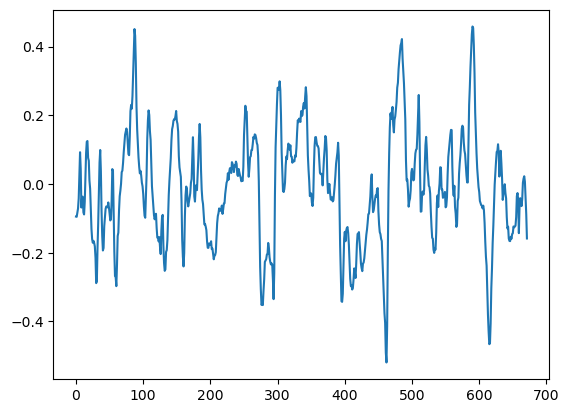

In [27]:
# Load values appear to have no trend, variance is generally even around avg level
plt.plot(load_long_z1_feb04.dropna().reset_index(drop=True).load_seasonally_differenced)

###### Apr 2004

In [28]:
# Seasonal differencing with 24th lag - Only for zone 1 (2004); subsetting the data for Apr 2004

load_long_z1_apr04 = load_long_z1.sort_values(by="timestamp").loc[(load_long_z1["zone_id"]==1)&(load_long_z1["year"]==2004)&(load_long_z1["month"]==4),['zone_id','year','month','day','hour','load','timestamp','load_rs','log_load_rs']]
s_differenced_apr04 = load_long_z1_apr04.sort_values(by="timestamp").loc[:, "log_load_rs"].diff(24)
load_long_z1_apr04['load_seasonally_differenced'] = s_differenced_apr04
load_long_z1_apr04.head()

,zone_id,year,month,day,hour,load,timestamp,load_rs,log_load_rs,load_seasonally_differenced
2184,1,2004,4,1,00:30,14095.0,2004-04-01 00:30:00,14.095,2.645820,NaN
2185,1,2004,4,1,01:30,13928.0,2004-04-01 01:30:00,13.928,2.633901,NaN
2186,1,2004,4,1,02:30,13916.0,2004-04-01 02:30:00,13.916,2.633039,NaN
2187,1,2004,4,1,03:30,14101.0,2004-04-01 03:30:00,14.101,2.646246,NaN
2188,1,2004,4,1,04:30,14710.0,2004-04-01 04:30:00,14.710,2.688528,NaN


In [29]:
# Removing missing values
load_long_z1_apr04.dropna().reset_index(drop=True).head()

,zone_id,year,month,day,hour,load,timestamp,load_rs,log_load_rs,load_seasonally_differenced
0,1,2004,4,2,00:30,15240.0,2004-04-02 00:30:00,15.240,2.723924,0.078103
1,1,2004,4,2,01:30,15126.0,2004-04-02 01:30:00,15.126,2.716415,0.082514
2,1,2004,4,2,02:30,15132.0,2004-04-02 02:30:00,15.132,2.716812,0.083772
3,1,2004,4,2,03:30,15290.0,2004-04-02 03:30:00,15.290,2.727199,0.080953
4,1,2004,4,2,04:30,15958.0,2004-04-02 04:30:00,15.958,2.769960,0.081433


In [30]:
# checking for stationarity after adjusting for seasonality
check_stationarity(load_long_z1_apr04.dropna().reset_index(drop=True).load_seasonally_differenced)

ADF Statistic: -6.376770179651941
p-value: 2.2736404210168964e-08
Stationary


The series is stationary!

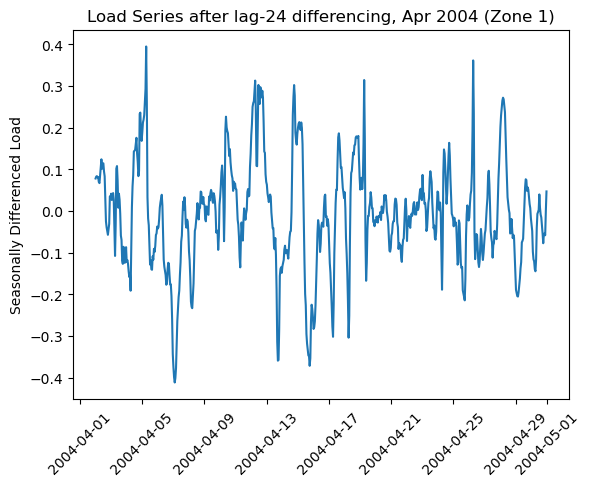

In [31]:
# Load values appear to have no trend, variance is generally even around avg level

import seaborn as sns
fig, ax = plt.subplots()
sns.lineplot(x=pd.to_datetime(load_long_z1_apr04.dropna().reset_index(drop=True).timestamp), y=load_long_z1_apr04.dropna().reset_index(drop=True).load_seasonally_differenced)
plt.ylabel("Seasonally Differenced Load")
plt.xlabel("")
ax.set_title("Load Series after lag-24 differencing, Apr 2004 (Zone 1)")
plt.xticks(rotation=45)
plt.show()

###### Jul 2004

In [32]:
# Seasonal differencing with 24th lag - Only for zone 1 (2004); subsetting the data for Jul 2004

load_long_z1_jul04 = load_long_z1.sort_values(by="timestamp").loc[(load_long_z1["zone_id"]==1)&(load_long_z1["year"]==2004)&(load_long_z1["month"]==7),['zone_id','year','month','day','hour','load','timestamp','load_rs','log_load_rs']]
s_differenced_jul04 = load_long_z1_jul04.sort_values(by="timestamp").loc[:, "log_load_rs"].diff(24)
load_long_z1_jul04['load_seasonally_differenced'] = s_differenced_jul04

# checking for stationarity after adjusting for seasonality and dropping missing values
check_stationarity(load_long_z1_jul04.dropna().reset_index(drop=True).load_seasonally_differenced)

ADF Statistic: -7.0652875239053134
p-value: 5.099339694550086e-10
Stationary


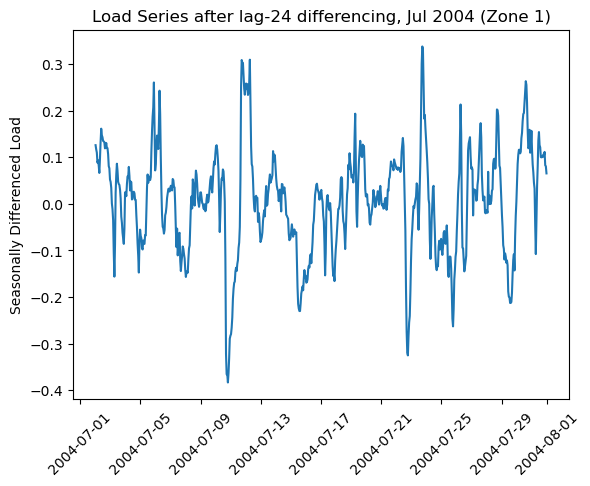

In [33]:
# Load values appear to have no trend, variance is generally even around avg level

import seaborn as sns
fig, ax = plt.subplots()
sns.lineplot(x=pd.to_datetime(load_long_z1_jul04.dropna().reset_index(drop=True).timestamp), y=load_long_z1_jul04.dropna().reset_index(drop=True).load_seasonally_differenced)
plt.ylabel("Seasonally Differenced Load")
plt.xlabel("")
ax.set_title("Load Series after lag-24 differencing, Jul 2004 (Zone 1)")
plt.xticks(rotation=45)
plt.show()

###### Oct 2004

In [34]:
# Seasonal differencing with 24th lag - Only for zone 1 (2004); subsetting the data for Oct 2004

load_long_z1_oct04 = load_long_z1.sort_values(by="timestamp").loc[(load_long_z1["zone_id"]==1)&(load_long_z1["year"]==2004)&(load_long_z1["month"]==10),['zone_id','year','month','day','hour','load','timestamp','load_rs','log_load_rs']]
s_differenced_oct04 = load_long_z1_oct04.sort_values(by="timestamp").loc[:, "log_load_rs"].diff(24)
load_long_z1_oct04['load_seasonally_differenced'] = s_differenced_oct04

# checking for stationarity after adjusting for seasonality and dropping missing values
check_stationarity(load_long_z1_oct04.dropna().reset_index(drop=True).load_seasonally_differenced)

ADF Statistic: -8.642832019440856
p-value: 5.36820862720378e-14
Stationary


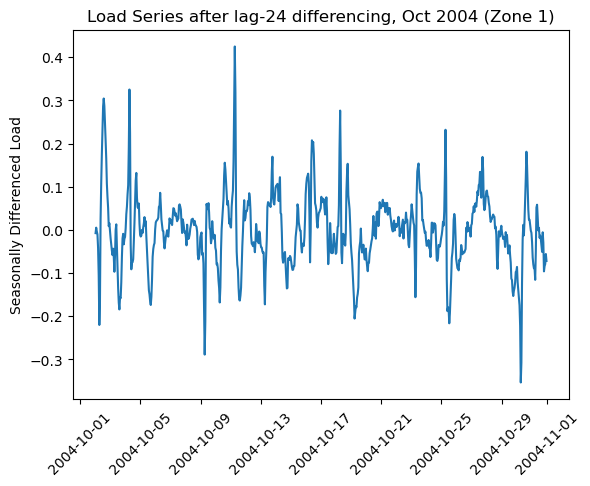

In [35]:
# Load values appear to have no trend, variance is generally even around avg level

import seaborn as sns
fig, ax = plt.subplots()
sns.lineplot(x=pd.to_datetime(load_long_z1_oct04.dropna().reset_index(drop=True).timestamp), y=load_long_z1_oct04.dropna().reset_index(drop=True).load_seasonally_differenced)
plt.ylabel("Seasonally Differenced Load")
plt.xlabel("")
ax.set_title("Load Series after lag-24 differencing, Oct 2004 (Zone 1)")
plt.xticks(rotation=45)
plt.show()

###### Dec 2004

In [36]:
# Seasonal differencing with 24th lag - Only for zone 1 (2004); subsetting the data for Dec 2004

load_long_z1_dec04 = load_long_z1.sort_values(by="timestamp").loc[(load_long_z1["zone_id"]==1)&(load_long_z1["year"]==2004)&(load_long_z1["month"]==12),['zone_id','year','month','day','hour','load','timestamp','load_rs','log_load_rs']]
s_differenced_dec04 = load_long_z1_dec04.sort_values(by="timestamp").loc[:, "log_load_rs"].diff(24)
load_long_z1_dec04['load_seasonally_differenced'] = s_differenced_dec04

# checking for stationarity after adjusting for seasonality and dropping missing values
check_stationarity(load_long_z1_dec04.dropna().reset_index(drop=True).load_seasonally_differenced)

ADF Statistic: -4.581923966418695
p-value: 0.00013945015777377424
Stationary


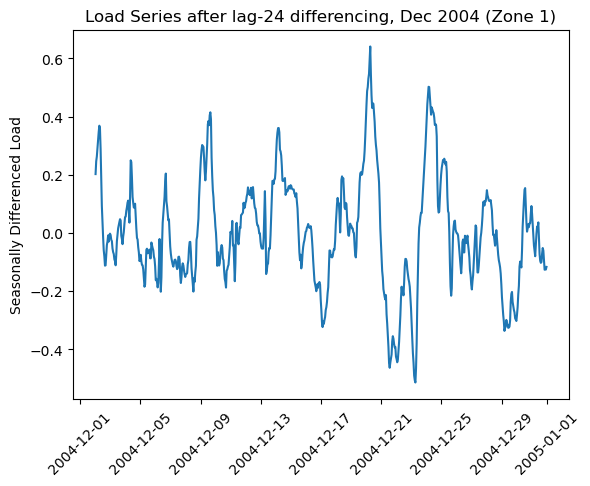

In [37]:
# Load values appear to have no trend, variance is generally even around avg level

import seaborn as sns
fig, ax = plt.subplots()
sns.lineplot(x=pd.to_datetime(load_long_z1_dec04.dropna().reset_index(drop=True).timestamp), y=load_long_z1_dec04.dropna().reset_index(drop=True).load_seasonally_differenced)
plt.ylabel("Seasonally Differenced Load")
plt.xlabel("")
ax.set_title("Load Series after lag-24 differencing, Dec 2004 (Zone 1)")
plt.xticks(rotation=45)
plt.show()

### ACFs and PACFs
Here, ACFs and PACFs are plotted on series after doing appropriate differencing.

##### Jan 2004

Text(0, 0.5, 'ACF')

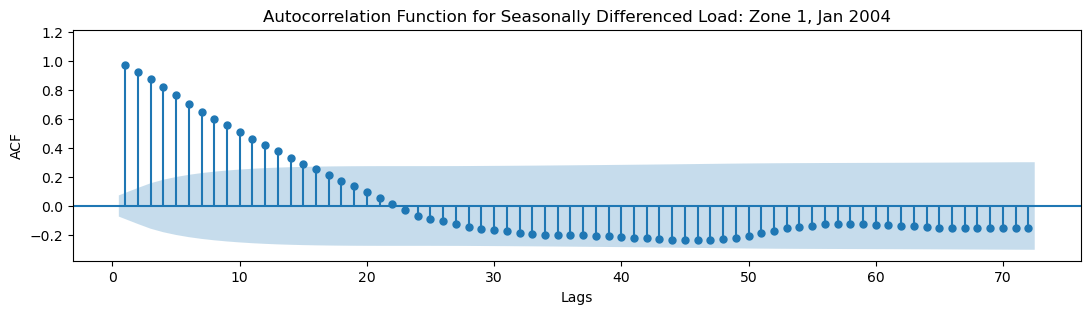

In [38]:
# Observing the ACF plot - Only for zone 1 (2004); subsetting the data for Jan 2004
from statsmodels.graphics.tsaplots import plot_acf

fig, ax = plt.subplots(figsize=(13,3))
plot_acf(load_long_z1_jan04.sort_values(by="timestamp").dropna().reset_index(drop=True).loc[:,"load_seasonally_differenced"], 
         lags=72, # lags for last 3 days
         ax=ax,
         zero=False, 
         bartlett_confint=True, 
         auto_ylims=True)

ax.set_title("Autocorrelation Function for Seasonally Differenced Load: Zone 1, Jan 2004")
ax.set_xlabel("Lags")
ax.set_ylabel("ACF")

Text(0, 0.5, 'ACF')

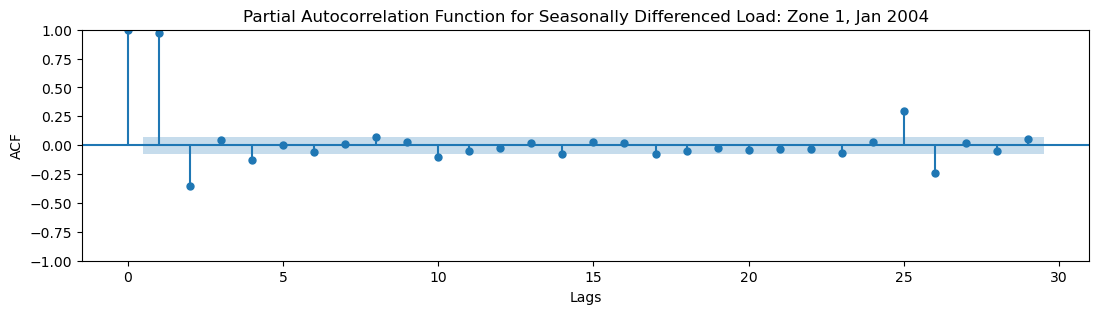

In [39]:
# Observing the PACF plot - Only for zone 1 (2004); subsetting the data for Jan 2004
from statsmodels.graphics.tsaplots import plot_pacf

fig, ax = plt.subplots(figsize=(13,3))
plot_pacf(load_long_z1_jan04.sort_values(by="timestamp").dropna().reset_index(drop=True).loc[:,"load_seasonally_differenced"],
         ax=ax)

ax.set_title("Partial Autocorrelation Function for Seasonally Differenced Load: Zone 1, Jan 2004")
ax.set_xlabel("Lags")
ax.set_ylabel("ACF")

##### Feb 2004

Text(0, 0.5, 'ACF')

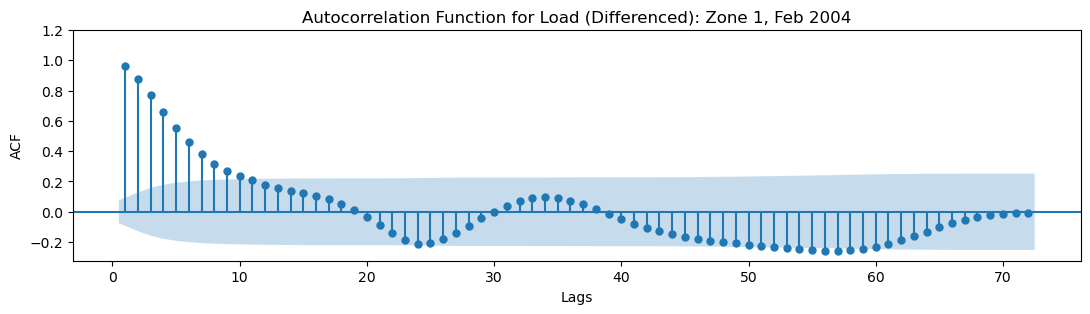

In [40]:
# Observing the ACF plot - Only for zone 1 (2004); subsetting the data for Feb 2004
from statsmodels.graphics.tsaplots import plot_acf

fig, ax = plt.subplots(figsize=(13,3))
plot_acf(load_long_z1_feb04.sort_values(by="timestamp").dropna().reset_index(drop=True).loc[:,"load_seasonally_differenced"], 
         lags=72, # lags for last 3 days
         ax=ax,
         zero=False, 
         bartlett_confint=True, 
         auto_ylims=True)

ax.set_title("Autocorrelation Function for Load (Differenced): Zone 1, Feb 2004")
ax.set_xlabel("Lags")
ax.set_ylabel("ACF")

Text(0, 0.5, 'ACF')

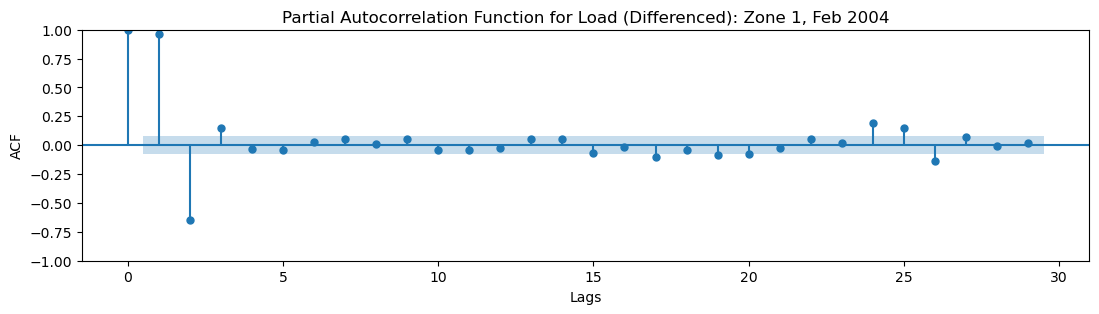

In [41]:
# Observing the PACF plot - Only for zone 1 (2004); subsetting the data for Feb 2004
from statsmodels.graphics.tsaplots import plot_pacf

fig, ax = plt.subplots(figsize=(13,3))
plot_pacf(load_long_z1_feb04.sort_values(by="timestamp").dropna().reset_index(drop=True).loc[:,"load_seasonally_differenced"],
         ax=ax)

ax.set_title("Partial Autocorrelation Function for Load (Differenced): Zone 1, Feb 2004")
ax.set_xlabel("Lags")
ax.set_ylabel("ACF")

##### Apr 2004

In [42]:
# How the seasonally differenced data appears
load_long_z1_apr04.sort_values(by="timestamp").dropna().reset_index(drop=True).head()

,zone_id,year,month,day,hour,load,timestamp,load_rs,log_load_rs,load_seasonally_differenced
0,1,2004,4,2,00:30,15240.0,2004-04-02 00:30:00,15.240,2.723924,0.078103
1,1,2004,4,2,01:30,15126.0,2004-04-02 01:30:00,15.126,2.716415,0.082514
2,1,2004,4,2,02:30,15132.0,2004-04-02 02:30:00,15.132,2.716812,0.083772
3,1,2004,4,2,03:30,15290.0,2004-04-02 03:30:00,15.290,2.727199,0.080953
4,1,2004,4,2,04:30,15958.0,2004-04-02 04:30:00,15.958,2.769960,0.081433


Text(0, 0.5, 'ACF')

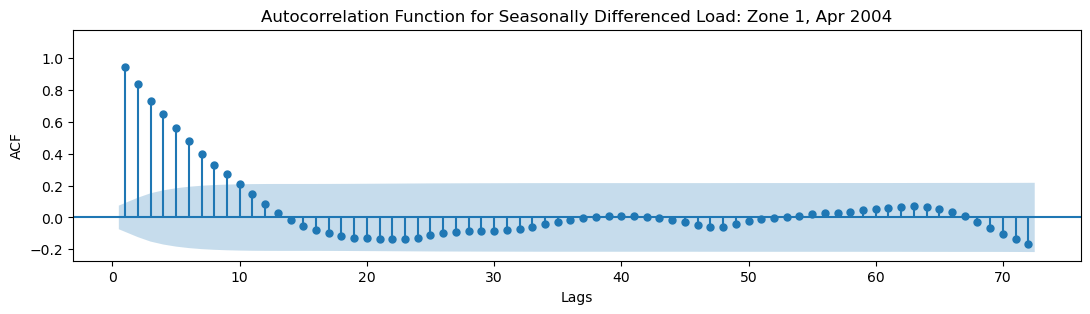

In [43]:
# Observing the ACF plot - Only for zone 1 (2004); subsetting the data for Apr 2004
from statsmodels.graphics.tsaplots import plot_acf

fig, ax = plt.subplots(figsize=(13,3))
plot_acf(load_long_z1_apr04.sort_values(by="timestamp").dropna().reset_index(drop=True).loc[:,"load_seasonally_differenced"], 
         lags=72, # lags for last 3 days
         ax=ax,
         zero=False, 
         bartlett_confint=True, 
         auto_ylims=True)

ax.set_title("Autocorrelation Function for Seasonally Differenced Load: Zone 1, Apr 2004")
ax.set_xlabel("Lags")
ax.set_ylabel("ACF")

Text(0, 0.5, 'ACF')

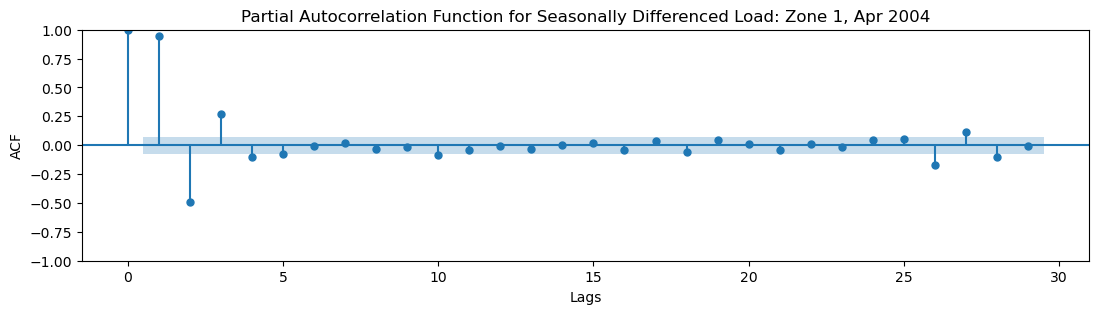

In [44]:
# Observing the PACF plot - Only for zone 1 (2004); subsetting the data for Apr 2004
from statsmodels.graphics.tsaplots import plot_pacf

fig, ax = plt.subplots(figsize=(13,3))
plot_pacf(load_long_z1_apr04.sort_values(by="timestamp").dropna().reset_index(drop=True).loc[:,"load_seasonally_differenced"],
         ax=ax)

ax.set_title("Partial Autocorrelation Function for Seasonally Differenced Load: Zone 1, Apr 2004")
ax.set_xlabel("Lags")
ax.set_ylabel("ACF")

##### Jul 2004

Text(0, 0.5, 'ACF')

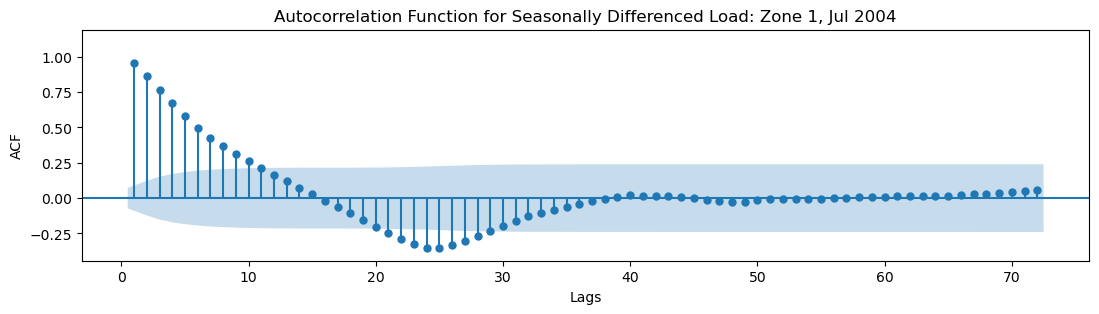

In [45]:
# Observing the ACF plot - Only for zone 1 (2004); subsetting the data for Jul 2004
from statsmodels.graphics.tsaplots import plot_acf

fig, ax = plt.subplots(figsize=(13,3))
plot_acf(load_long_z1_jul04.sort_values(by="timestamp").dropna().reset_index(drop=True).loc[:,"load_seasonally_differenced"], 
         lags=72, # lags for last 3 days
         ax=ax,
         zero=False, 
         bartlett_confint=True, 
         auto_ylims=True)

ax.set_title("Autocorrelation Function for Seasonally Differenced Load: Zone 1, Jul 2004")
ax.set_xlabel("Lags")
ax.set_ylabel("ACF")

Text(0, 0.5, 'ACF')

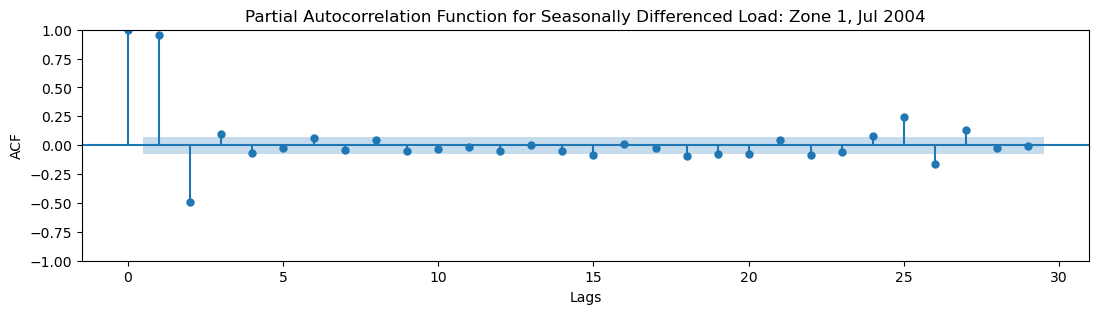

In [46]:
# Observing the PACF plot - Only for zone 1 (2004); subsetting the data for Jul 2004
from statsmodels.graphics.tsaplots import plot_pacf

fig, ax = plt.subplots(figsize=(13,3))
plot_pacf(load_long_z1_jul04.sort_values(by="timestamp").dropna().reset_index(drop=True).loc[:,"load_seasonally_differenced"],
         ax=ax)

ax.set_title("Partial Autocorrelation Function for Seasonally Differenced Load: Zone 1, Jul 2004")
ax.set_xlabel("Lags")
ax.set_ylabel("ACF")

##### Oct 2004

Text(0, 0.5, 'ACF')

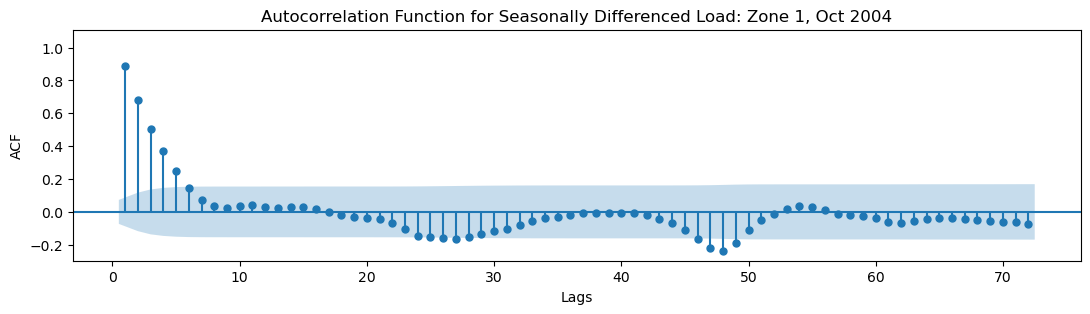

In [47]:
# Observing the ACF plot - Only for zone 1 (2004); subsetting the data for Oct 2004
from statsmodels.graphics.tsaplots import plot_acf

fig, ax = plt.subplots(figsize=(13,3))
plot_acf(load_long_z1_oct04.sort_values(by="timestamp").dropna().reset_index(drop=True).loc[:,"load_seasonally_differenced"], 
         lags=72, # lags for last 3 days
         ax=ax,
         zero=False, 
         bartlett_confint=True, 
         auto_ylims=True)

ax.set_title("Autocorrelation Function for Seasonally Differenced Load: Zone 1, Oct 2004")
ax.set_xlabel("Lags")
ax.set_ylabel("ACF")

Text(0, 0.5, 'ACF')

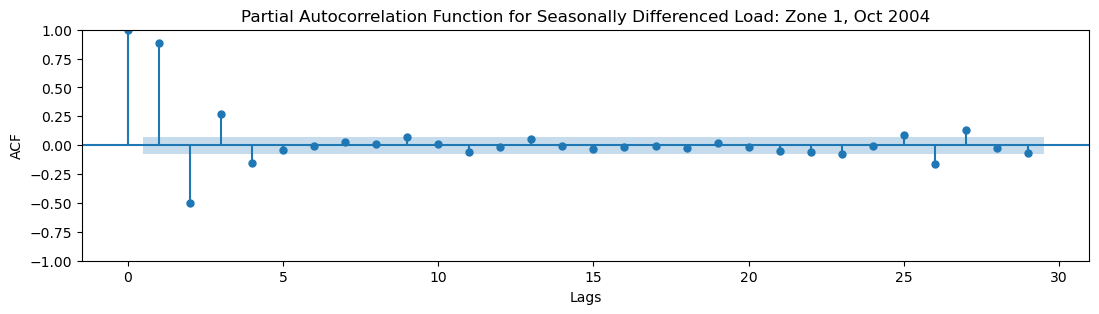

In [48]:
# Observing the PACF plot - Only for zone 1 (2004); subsetting the data for Oct 2004
from statsmodels.graphics.tsaplots import plot_pacf

fig, ax = plt.subplots(figsize=(13,3))
plot_pacf(load_long_z1_oct04.sort_values(by="timestamp").dropna().reset_index(drop=True).loc[:,"load_seasonally_differenced"],
         ax=ax)

ax.set_title("Partial Autocorrelation Function for Seasonally Differenced Load: Zone 1, Oct 2004")
ax.set_xlabel("Lags")
ax.set_ylabel("ACF")

##### Dec 2004

Text(0, 0.5, 'ACF')

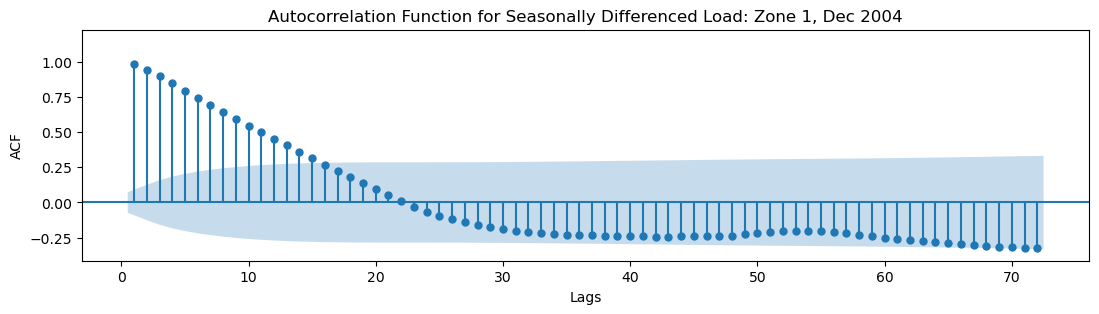

In [49]:
# Observing the ACF plot - Only for zone 1 (2004); subsetting the data for Dec 2004
from statsmodels.graphics.tsaplots import plot_acf

fig, ax = plt.subplots(figsize=(13,3))
plot_acf(load_long_z1_dec04.sort_values(by="timestamp").dropna().reset_index(drop=True).loc[:,"load_seasonally_differenced"], 
         lags=72, # lags for last 3 days
         ax=ax,
         zero=False, 
         bartlett_confint=True, 
         auto_ylims=True)

ax.set_title("Autocorrelation Function for Seasonally Differenced Load: Zone 1, Dec 2004")
ax.set_xlabel("Lags")
ax.set_ylabel("ACF")

Text(0, 0.5, 'ACF')

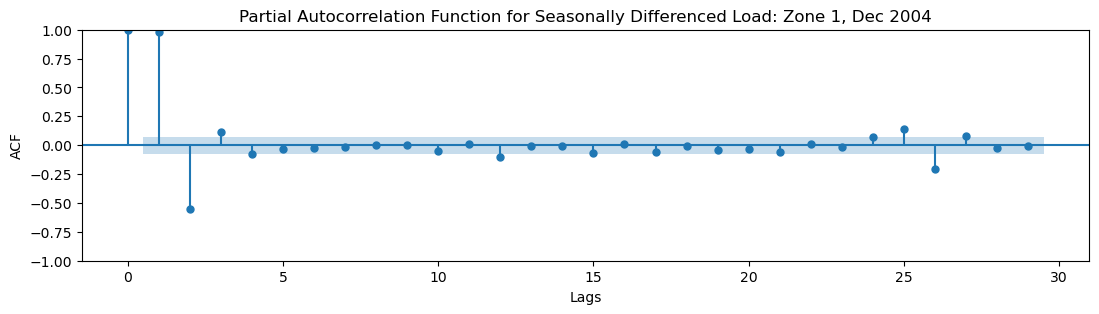

In [50]:
# Observing the PACF plot - Only for zone 1 (2004); subsetting the data for Dec 2004
from statsmodels.graphics.tsaplots import plot_pacf

fig, ax = plt.subplots(figsize=(13,3))
plot_pacf(load_long_z1_dec04.sort_values(by="timestamp").dropna().reset_index(drop=True).loc[:,"load_seasonally_differenced"],
         ax=ax)

ax.set_title("Partial Autocorrelation Function for Seasonally Differenced Load: Zone 1, Dec 2004")
ax.set_xlabel("Lags")
ax.set_ylabel("ACF")

Observing the plots across many portions of the series, we see:
- from ACF that there is no sharp drop but slow decay (suggesting process is likely not pure MA)
- from PACF that lags till 2 or 3 are significant (non-seasonal order) along with significance at lag 24 (easonal order)
- PACF does show sinusoidal pattern (suggesting an AR process)
- Previous seasonal lags are likely important

### SARIMAX - Without exogenous regressors
Here the order for both non-seasonal and seasonal AR, MA must be found out. We are aware that there is seasonality and PACF seem to become significant again at lag 24.<br>
Hence the model being worked at is either:
- SARIMA((1,0,0),(P,1,0,24)) 
- SARIMA((2,0,0),(P,1,0,24))

Here: P can be any value > 0.

##### Testing on Last Week of Jan 2004 (Zone 1)
Last week of Jan 2004 is used for testing. Multiple SARIMA models are evaluated and compared.
>NOTE: Length of training data can affect test performance. 

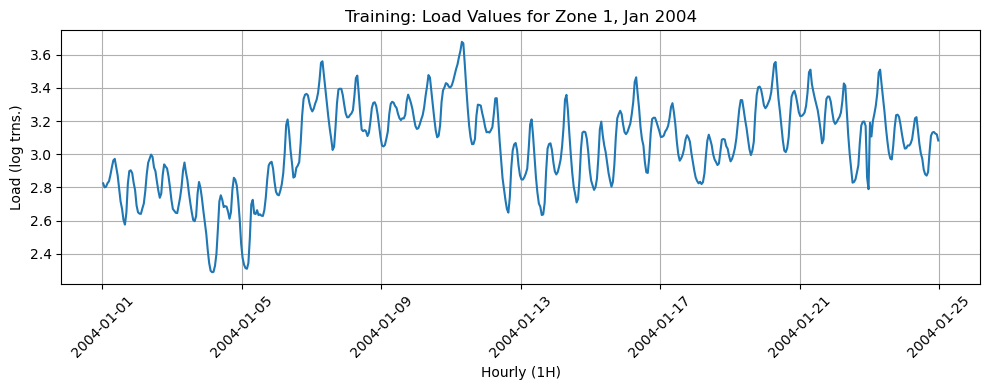

In [93]:
# Creating training data
load_long_z1_jan04_train = load_long_z1.loc[(load_long_z1.year == 2004) & (load_long_z1.month == 1),["timestamp","log_load_rs"]]
load_long_z1_jan04_train = load_long_z1_jan04_train.set_index("timestamp")
load_long_z1_jan04_train = load_long_z1_jan04_train[:'2004-01-24 23:30:00']
load_long_z1_jan04_train.index = pd.to_datetime(load_long_z1_jan04_train.index)

import seaborn as sns
fig, ax = plt.subplots(figsize=(10, 4))
sns.lineplot(data=load_long_z1_jan04_train, x=load_long_z1_jan04_train.index, y=load_long_z1_jan04_train.log_load_rs, ax=ax)
ax.set_title("Training: Load Values for Zone 1, Jan 2004")
ax.set_xlabel("Hourly (1H)")
ax.set_ylabel("Load (log trns.)")
ax.grid(True)
ax.tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()

In [63]:
# Comparing models - auto_arima

import pmdarima as pm
smodel_jan = pm.auto_arima(load_long_z1_jan04_train["log_load_rs"], start_p=0, start_q=0,test='adf',
                         max_p=2, max_q=1, m=24,
                         start_P=0, start_Q=0, max_P=4, max_Q=1, seasonal=True,
                         d=0, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=False)

 ARIMA(0,0,0)(0,1,0)[24] intercept   : AIC=-222.247, Time=0.35 sec
 ARIMA(0,0,0)(0,1,1)[24] intercept   : AIC=-220.894, Time=1.00 sec
 ARIMA(0,0,0)(1,1,0)[24] intercept   : AIC=-220.504, Time=1.00 sec
 ARIMA(0,0,0)(1,1,1)[24] intercept   : AIC=-227.674, Time=3.76 sec
 ARIMA(0,0,0)(2,1,0)[24] intercept   : AIC=-268.392, Time=3.28 sec
 ARIMA(0,0,0)(2,1,1)[24] intercept   : AIC=inf, Time=13.05 sec
 ARIMA(0,0,0)(3,1,0)[24] intercept   : AIC=-276.659, Time=6.59 sec
 ARIMA(0,0,0)(3,1,1)[24] intercept   : AIC=inf, Time=25.34 sec
 ARIMA(0,0,0)(4,1,0)[24] intercept   : AIC=-275.183, Time=16.11 sec
 ARIMA(0,0,0)(4,1,1)[24] intercept   : AIC=inf, Time=44.72 sec
 ARIMA(0,0,1)(0,1,0)[24] intercept   : AIC=-882.468, Time=1.02 sec
 ARIMA(0,0,1)(0,1,1)[24] intercept   : AIC=-881.915, Time=4.53 sec
 ARIMA(0,0,1)(1,1,0)[24] intercept   : AIC=-881.175, Time=2.70 sec
 ARIMA(0,0,1)(1,1,1)[24] intercept   : AIC=inf, Time=10.02 sec
 ARIMA(0,0,1)(2,1,0)[24] intercept   : AIC=-915.940, Time=8.31 sec
 ARIMA(0,0

C:\Users\singh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
C:\Users\singh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


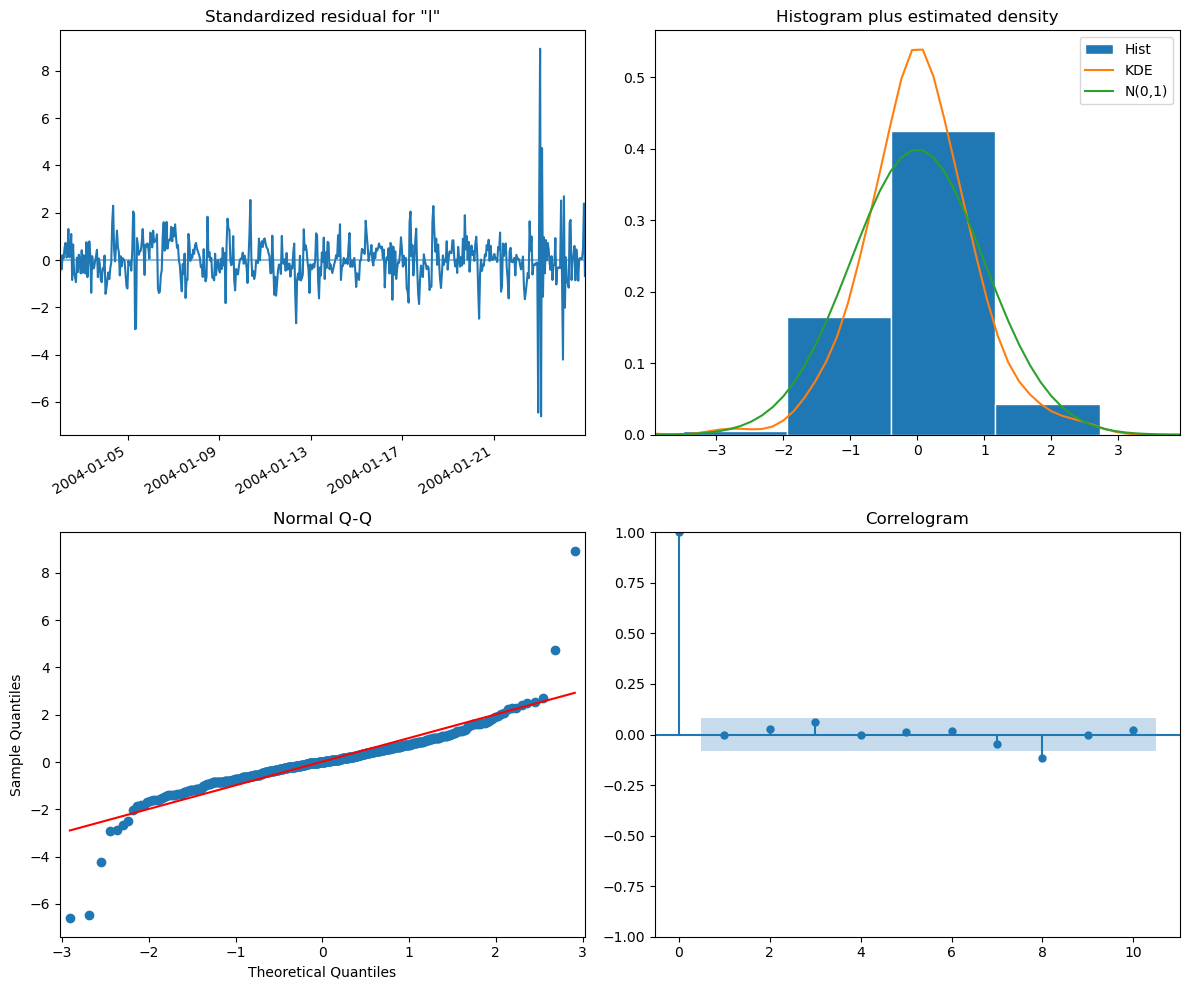

In [94]:
# Diagnostics: ARIMA(2,0,1)(2,1,0)[24]

import statsmodels.api as sm
SARIMA_model = sm.tsa.statespace.SARIMAX(
        load_long_z1_jan04_train["log_load_rs"], 
        order=(2,0,1),  # non-seasonal with no differencing
        seasonal_order=(2,1,0,24) # seasonal differencing
        )

SARIMA_model_fit = SARIMA_model.fit(disp=False)
SARIMA_model_fit.plot_diagnostics(figsize=(12,10))
plt.tight_layout()
plt.show()

The correlogram shows no meaningful remaining autocorrelation (all lags inside the CI), so SARIMA(1,0,1)(2,1,0,24) is doing a good job removing serial dependence.

But the QQ plot, histogram/KDE and the standardized residuals time plot show heavy tails and a few large outliers (and some skew). That means residuals are not Gaussian and there is heteroskedasticity/outliers.

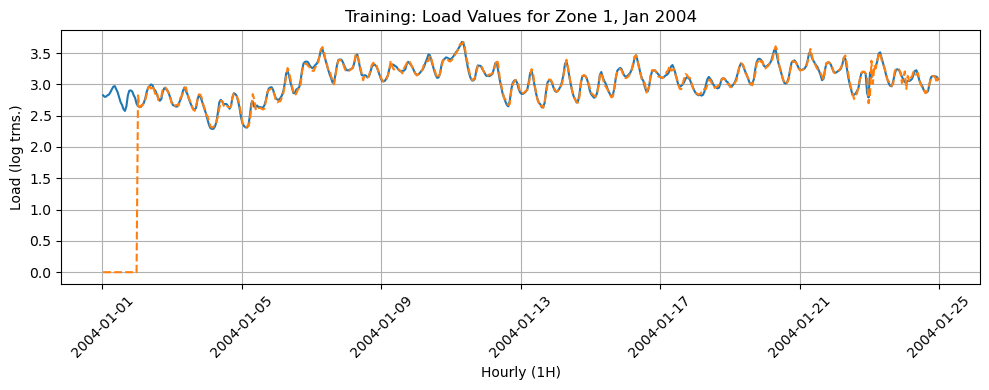

In [95]:
# Fit on the training data

fig, ax = plt.subplots(figsize=(10, 4))
sns.lineplot(data=load_long_z1_jan04_train, x=load_long_z1_jan04_train.index, y=load_long_z1_jan04_train.log_load_rs, ax=ax)
sns.lineplot(SARIMA_model_fit.fittedvalues, linestyle = '--')
ax.set_title("Training: Load Values for Zone 1, Jan 2004")
ax.set_xlabel("Hourly (1H)")
ax.set_ylabel("Load (log trns.)")
ax.grid(True)
ax.tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()

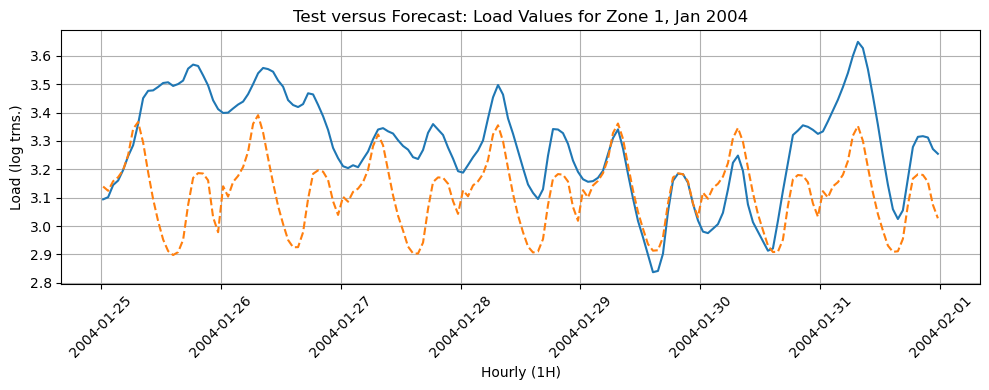

In [96]:
# Predicting 24*7 steps ahead
forecast_jan04 = SARIMA_model_fit.get_forecast(steps=24*7).predicted_mean

# Creating test data
load_long_z1_jan04_test = load_long_z1.loc[(load_long_z1.year == 2004) & (load_long_z1.month == 1),["timestamp","log_load_rs"]]
load_long_z1_jan04_test = load_long_z1_jan04_test.set_index("timestamp")
load_long_z1_jan04_test = load_long_z1_jan04_test['2004-01-25 00:30:00':]
load_long_z1_jan04_test.index = pd.to_datetime(load_long_z1_jan04_test.index)

# Fit on the test data

fig, ax = plt.subplots(figsize=(10, 4))
sns.lineplot(data=load_long_z1_jan04_test, x=load_long_z1_jan04_test.index, y=load_long_z1_jan04_test.log_load_rs, ax=ax)
sns.lineplot(forecast_jan04, linestyle = '--')
ax.set_title("Test versus Forecast: Load Values for Zone 1, Jan 2004")
ax.set_xlabel("Hourly (1H)")
ax.set_ylabel("Load (log trns.)")
ax.grid(True)
ax.tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()

In [97]:
# Performance on test set

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
print(f"R2 score: {r2_score(load_long_z1_jan04_test.log_load_rs, forecast_jan04)}")
print(f'RMSE score: {np.sqrt(mean_squared_error(load_long_z1_jan04_test.log_load_rs, forecast_jan04))}')
print(f'MAE score: {mean_absolute_error(load_long_z1_jan04_test.log_load_rs, forecast_jan04)}')
print(f'MAPE score: {mean_absolute_percentage_error(load_long_z1_jan04_test.log_load_rs, forecast_jan04)}')

R2 score: -0.8183987001948643
RMSE score: 0.23566224825763776
MAE score: 0.18748799588166407
MAPE score: 0.05574876578406278


The performance is lower compared to Exponential Smoothing, but better than other approaches.

##### Testing on Last Week of Apr 2004 (Zone 1)
Last week of Apr 2004 is used for testing. Multiple SARIMA models are evaluated and compared.

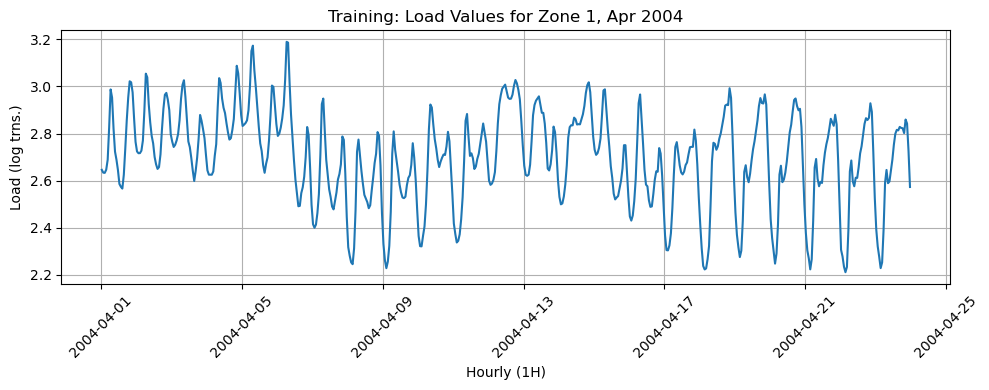

In [98]:
# Creating training data
load_long_z1_apr04_train = load_long_z1.loc[(load_long_z1.year == 2004) & (load_long_z1.month == 4),["timestamp","log_load_rs"]]
load_long_z1_apr04_train = load_long_z1_apr04_train.set_index("timestamp")
load_long_z1_apr04_train = load_long_z1_apr04_train[:'2004-04-23 23:30:00']
load_long_z1_apr04_train.index = pd.to_datetime(load_long_z1_apr04_train.index)

import seaborn as sns
fig, ax = plt.subplots(figsize=(10, 4))
sns.lineplot(data=load_long_z1_apr04_train, x=load_long_z1_apr04_train.index, y=load_long_z1_apr04_train.log_load_rs, ax=ax)
ax.set_title("Training: Load Values for Zone 1, Apr 2004")
ax.set_xlabel("Hourly (1H)")
ax.set_ylabel("Load (log trns.)")
ax.grid(True)
ax.tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()

In [69]:
# Comparing models - auto_arima

import pmdarima as pm
smodel_apr = pm.auto_arima(load_long_z1_apr04_train["log_load_rs"], start_p=0, start_q=0,test='adf',
                         max_p=2, max_q=1, m=24,
                         start_P=0, start_Q=0, max_P=4, max_Q=1, seasonal=True,
                         d=0, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=False)

 ARIMA(0,0,0)(0,1,0)[24] intercept   : AIC=-606.059, Time=0.18 sec
 ARIMA(0,0,0)(0,1,1)[24] intercept   : AIC=-614.875, Time=1.14 sec
 ARIMA(0,0,0)(1,1,0)[24] intercept   : AIC=-612.706, Time=2.39 sec
 ARIMA(0,0,0)(1,1,1)[24] intercept   : AIC=inf, Time=4.11 sec
 ARIMA(0,0,0)(2,1,0)[24] intercept   : AIC=-614.200, Time=4.02 sec
 ARIMA(0,0,0)(2,1,1)[24] intercept   : AIC=inf, Time=9.99 sec
 ARIMA(0,0,0)(3,1,0)[24] intercept   : AIC=-626.182, Time=10.58 sec
 ARIMA(0,0,0)(3,1,1)[24] intercept   : AIC=inf, Time=20.58 sec
 ARIMA(0,0,0)(4,1,0)[24] intercept   : AIC=-634.164, Time=14.50 sec
 ARIMA(0,0,0)(4,1,1)[24] intercept   : AIC=-684.892, Time=31.77 sec
 ARIMA(0,0,1)(0,1,0)[24] intercept   : AIC=-1232.666, Time=1.65 sec
 ARIMA(0,0,1)(0,1,1)[24] intercept   : AIC=-1247.334, Time=4.13 sec
 ARIMA(0,0,1)(1,1,0)[24] intercept   : AIC=-1244.082, Time=4.23 sec
 ARIMA(0,0,1)(1,1,1)[24] intercept   : AIC=inf, Time=9.49 sec
 ARIMA(0,0,1)(2,1,0)[24] intercept   : AIC=-1245.088, Time=8.29 sec
 ARIMA(

C:\Users\singh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
C:\Users\singh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


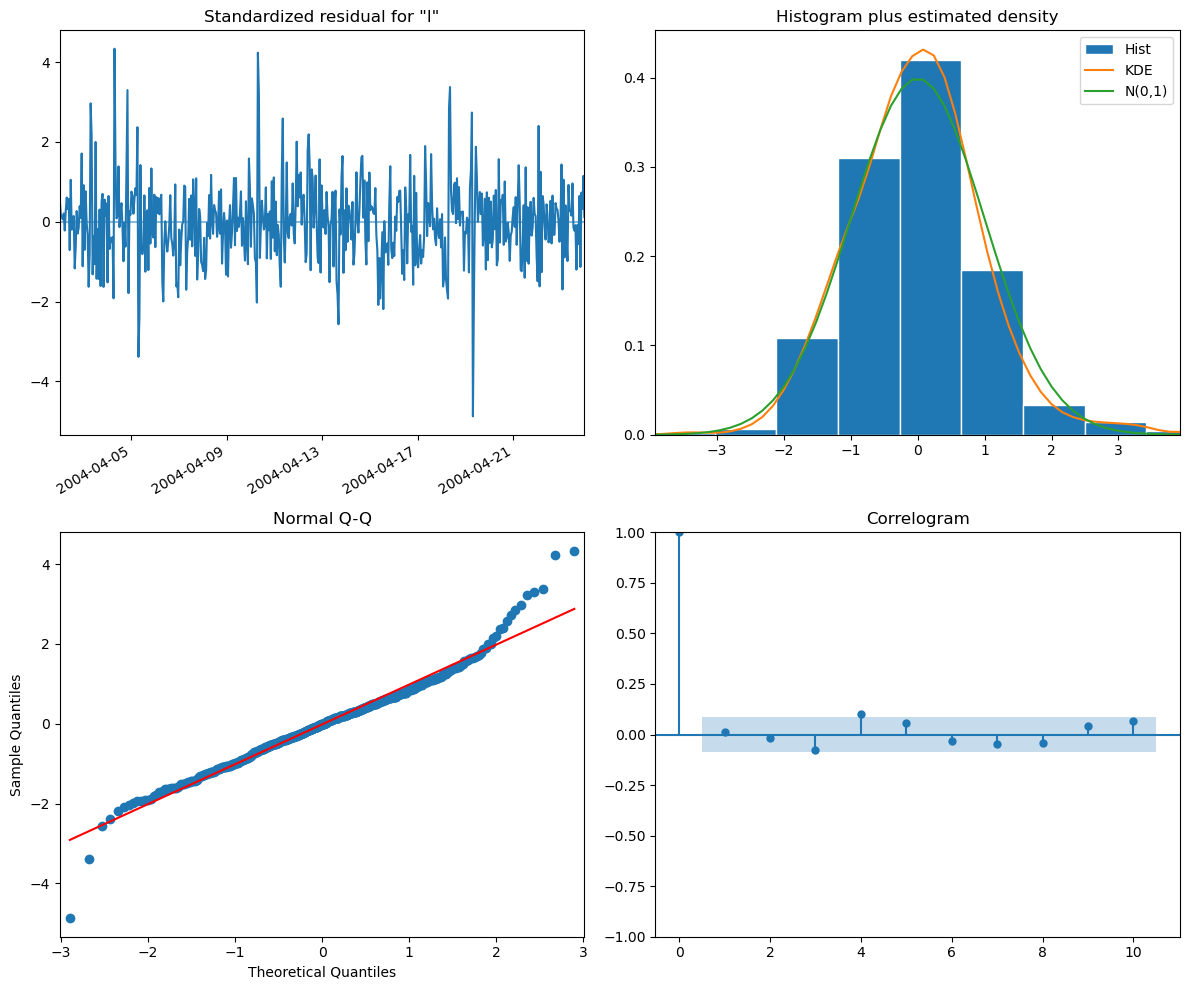

In [99]:
# Diagnostics: ARIMA(2,0,1)(2,1,0)[24]

import statsmodels.api as sm
SARIMA_model = sm.tsa.statespace.SARIMAX(
        load_long_z1_apr04_train["log_load_rs"], 
        order=(2,0,1),  # non-seasonal with no differencing
        seasonal_order=(2,1,0,24) # seasonal differencing
        )

SARIMA_model_fit = SARIMA_model.fit(disp=False)
SARIMA_model_fit.plot_diagnostics(figsize=(12,10))
plt.tight_layout()
plt.show()

Residual plot is much better:
- correlogram shows that autocorrelation has been captured well by the model
- q-q plot shows that residuals are roughly Gaussian (although some deviation in tails)

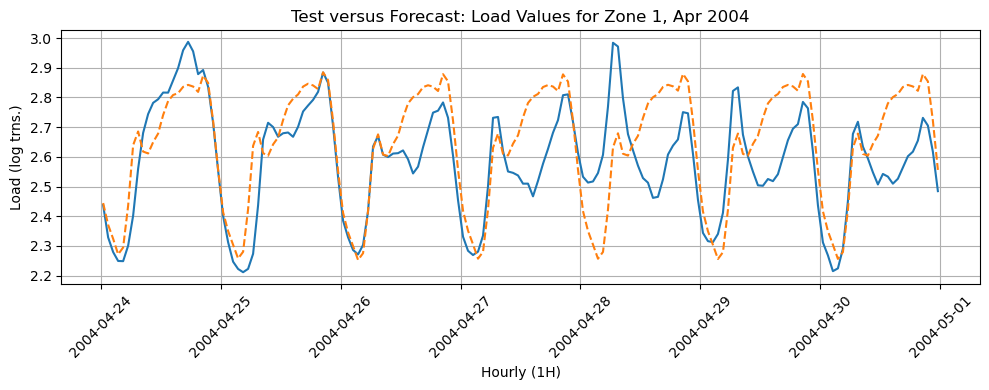

In [100]:
# Predicting 24*7 steps ahead
forecast_apr04 = SARIMA_model_fit.get_forecast(steps=24*7).predicted_mean

# Creating test data
load_long_z1_apr04_test = load_long_z1.loc[(load_long_z1.year == 2004) & (load_long_z1.month == 4),["timestamp","log_load_rs"]]
load_long_z1_apr04_test = load_long_z1_apr04_test.set_index("timestamp")
load_long_z1_apr04_test = load_long_z1_apr04_test['2004-04-24 00:30:00':]
load_long_z1_apr04_test.index = pd.to_datetime(load_long_z1_apr04_test.index)

# Fit on the test data

fig, ax = plt.subplots(figsize=(10, 4))
sns.lineplot(data=load_long_z1_apr04_test, x=load_long_z1_apr04_test.index, y=load_long_z1_apr04_test.log_load_rs, ax=ax)
sns.lineplot(forecast_apr04, linestyle = '--')
ax.set_title("Test versus Forecast: Load Values for Zone 1, Apr 2004")
ax.set_xlabel("Hourly (1H)")
ax.set_ylabel("Load (log trns.)")
ax.grid(True)
ax.tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()

In [101]:
# Performance on test set

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
print(f"R2 score: {r2_score(load_long_z1_apr04_test.log_load_rs, forecast_apr04)}")
print(f'RMSE score: {np.sqrt(mean_squared_error(load_long_z1_apr04_test.log_load_rs, forecast_apr04))}')
print(f'MAE score: {mean_absolute_error(load_long_z1_apr04_test.log_load_rs, forecast_apr04)}')
print(f'MAPE score: {mean_absolute_percentage_error(load_long_z1_apr04_test.log_load_rs, forecast_apr04)}')

R2 score: 0.3292404678728912
RMSE score: 0.15147295894581583
MAE score: 0.11837005661241683
MAPE score: 0.04591814673433202


R2 score appears to be better than ES. This means that SARIMA model is explaining variance slightly better.

##### Testing on Last Week of Jul 2004 (Zone 1)
Last week of Jul 2004 is used for testing. Multiple SARIMA models are evaluated and compared.

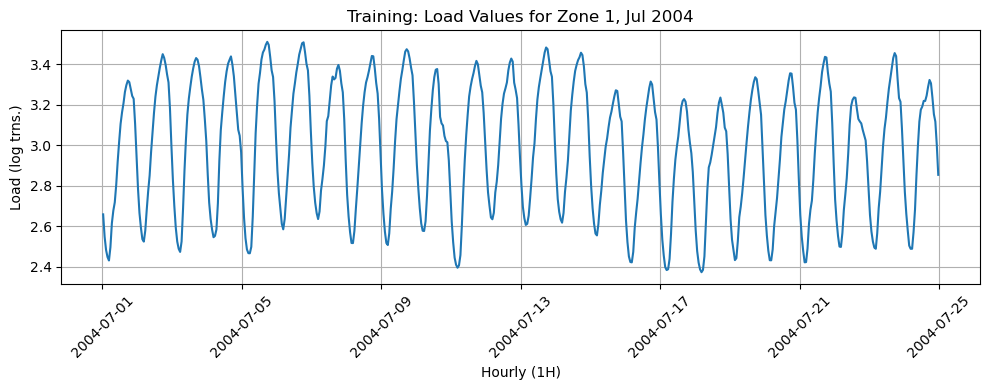

In [102]:
# Creating training data
load_long_z1_jul04_train = load_long_z1.loc[(load_long_z1.year == 2004) & (load_long_z1.month == 7),["timestamp","log_load_rs"]]
load_long_z1_jul04_train = load_long_z1_jul04_train.set_index("timestamp")
load_long_z1_jul04_train = load_long_z1_jul04_train[:'2004-07-24 23:30:00']
load_long_z1_jul04_train.index = pd.to_datetime(load_long_z1_jul04_train.index)

import seaborn as sns
fig, ax = plt.subplots(figsize=(10, 4))
sns.lineplot(data=load_long_z1_jul04_train, x=load_long_z1_jul04_train.index, y=load_long_z1_jul04_train.log_load_rs, ax=ax)
ax.set_title("Training: Load Values for Zone 1, Jul 2004")
ax.set_xlabel("Hourly (1H)")
ax.set_ylabel("Load (log trns.)")
ax.grid(True)
ax.tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()

In [74]:
# Comparing models - auto_arima

import pmdarima as pm
smodel_jul = pm.auto_arima(load_long_z1_jul04_train["log_load_rs"], start_p=0, start_q=0,test='adf',
                         max_p=2, max_q=1, m=24,
                         start_P=0, start_Q=0, max_P=4, max_Q=1, seasonal=True,
                         d=0, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=False)

 ARIMA(0,0,0)(0,1,0)[24] intercept   : AIC=-848.997, Time=0.50 sec
 ARIMA(0,0,0)(0,1,1)[24] intercept   : AIC=inf, Time=3.98 sec
 ARIMA(0,0,0)(1,1,0)[24] intercept   : AIC=-960.982, Time=1.77 sec
 ARIMA(0,0,0)(1,1,1)[24] intercept   : AIC=inf, Time=7.61 sec
 ARIMA(0,0,0)(2,1,0)[24] intercept   : AIC=-969.472, Time=5.62 sec
 ARIMA(0,0,0)(2,1,1)[24] intercept   : AIC=inf, Time=13.02 sec
 ARIMA(0,0,0)(3,1,0)[24] intercept   : AIC=-968.560, Time=12.25 sec
 ARIMA(0,0,0)(3,1,1)[24] intercept   : AIC=inf, Time=26.24 sec
 ARIMA(0,0,0)(4,1,0)[24] intercept   : AIC=-992.561, Time=16.12 sec
 ARIMA(0,0,0)(4,1,1)[24] intercept   : AIC=inf, Time=44.94 sec
 ARIMA(0,0,1)(0,1,0)[24] intercept   : AIC=-1490.682, Time=1.38 sec
 ARIMA(0,0,1)(0,1,1)[24] intercept   : AIC=inf, Time=5.48 sec
 ARIMA(0,0,1)(1,1,0)[24] intercept   : AIC=-1599.463, Time=2.88 sec
 ARIMA(0,0,1)(1,1,1)[24] intercept   : AIC=inf, Time=9.54 sec
 ARIMA(0,0,1)(2,1,0)[24] intercept   : AIC=-1610.071, Time=7.29 sec
 ARIMA(0,0,1)(2,1,1)[2

C:\Users\singh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
C:\Users\singh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


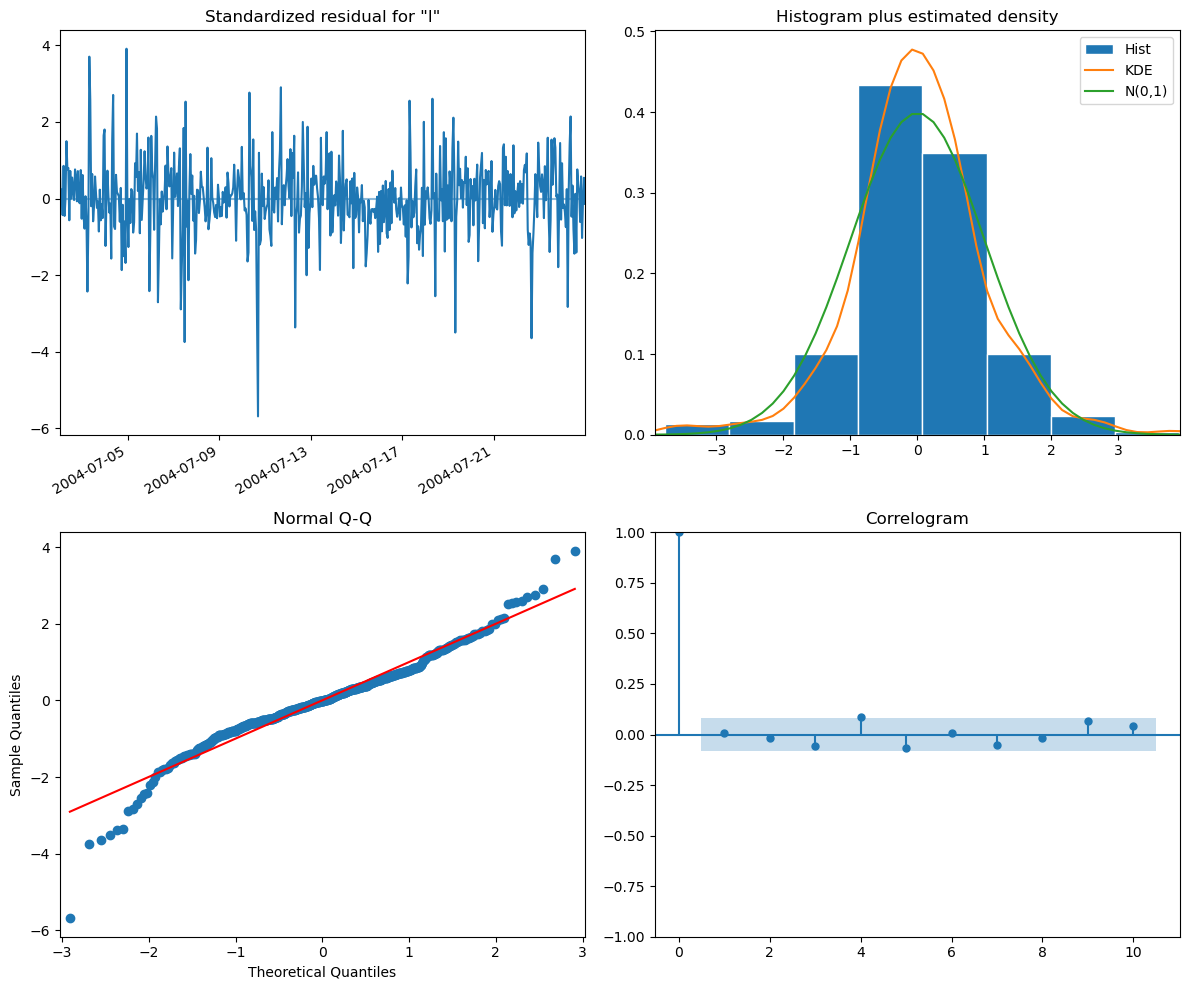

In [103]:
# Diagnostics: ARIMA(2,0,1)(2,1,0)[24]

import statsmodels.api as sm
SARIMA_model = sm.tsa.statespace.SARIMAX(
        load_long_z1_jul04_train["log_load_rs"], 
        order=(2,0,1),  # non-seasonal with no differencing
        seasonal_order=(2,1,0,24) # seasonal differencing
        )

SARIMA_model_fit = SARIMA_model.fit(disp=False)
SARIMA_model_fit.plot_diagnostics(figsize=(12,10))
plt.tight_layout()
plt.show()

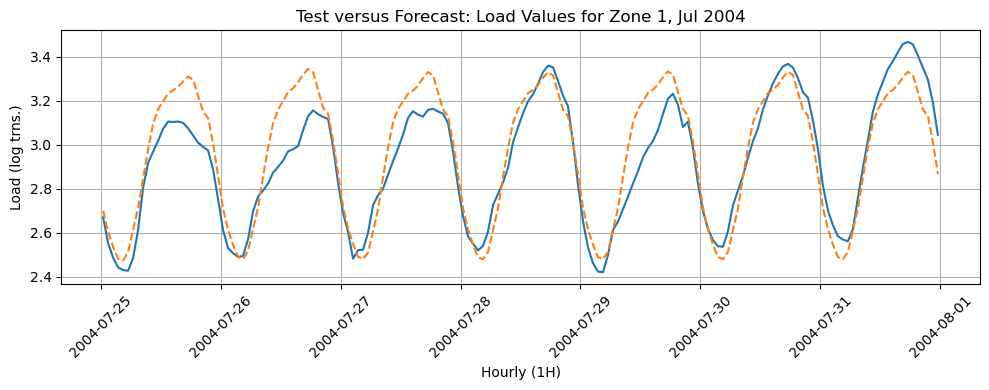

In [104]:
# Predicting 24*7 steps ahead
forecast_jul04 = SARIMA_model_fit.get_forecast(steps=24*7).predicted_mean

# Creating test data
load_long_z1_jul04_test = load_long_z1.loc[(load_long_z1.year == 2004) & (load_long_z1.month == 7),["timestamp","log_load_rs"]]
load_long_z1_jul04_test = load_long_z1_jul04_test.set_index("timestamp")
load_long_z1_jul04_test = load_long_z1_jul04_test['2004-07-25 00:30:00':]
load_long_z1_jul04_test.index = pd.to_datetime(load_long_z1_jul04_test.index)

# Fit on the test data

fig, ax = plt.subplots(figsize=(10, 4))
sns.lineplot(data=load_long_z1_jul04_test, x=load_long_z1_jul04_test.index, y=load_long_z1_jul04_test.log_load_rs, ax=ax)
sns.lineplot(forecast_jul04, linestyle = '--')
ax.set_title("Test versus Forecast: Load Values for Zone 1, Jul 2004")
ax.set_xlabel("Hourly (1H)")
ax.set_ylabel("Load (log trns.)")
ax.grid(True)
ax.tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()

In [105]:
# Performance on test set
print(f"R2 score: {r2_score(load_long_z1_jul04_test.log_load_rs, forecast_jul04)}")
print(f'RMSE score: {np.sqrt(mean_squared_error(load_long_z1_jul04_test.log_load_rs, forecast_jul04))}')
print(f'MAE score: {mean_absolute_error(load_long_z1_jul04_test.log_load_rs, forecast_jul04)}')
print(f'MAPE score: {mean_absolute_percentage_error(load_long_z1_jul04_test.log_load_rs, forecast_jul04)}')

R2 score: 0.8184648325462369
RMSE score: 0.11973668541440217
MAE score: 0.09619490188414642
MAPE score: 0.03259858358002626


##### Testing on Last Week of Oct 2004 (Zone 1)
Last week of Oct 2004 is used for testing. Multiple SARIMA models are evaluated and compared.

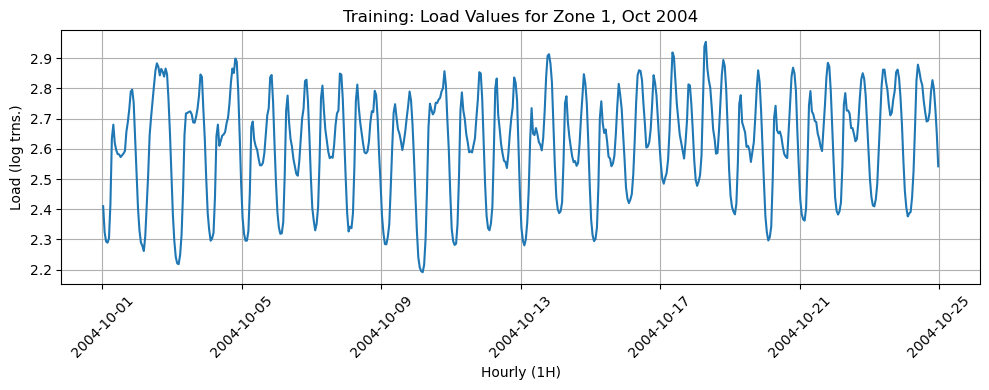

In [106]:
# Creating training data
load_long_z1_oct04_train = load_long_z1.loc[(load_long_z1.year == 2004) & (load_long_z1.month == 10),["timestamp","log_load_rs"]]
load_long_z1_oct04_train = load_long_z1_oct04_train.set_index("timestamp")
load_long_z1_oct04_train = load_long_z1_oct04_train[:'2004-10-24 23:30:00']
load_long_z1_oct04_train.index = pd.to_datetime(load_long_z1_oct04_train.index)

import seaborn as sns
fig, ax = plt.subplots(figsize=(10, 4))
sns.lineplot(data=load_long_z1_oct04_train, x=load_long_z1_oct04_train.index, y=load_long_z1_oct04_train.log_load_rs, ax=ax)
ax.set_title("Training: Load Values for Zone 1, Oct 2004")
ax.set_xlabel("Hourly (1H)")
ax.set_ylabel("Load (log trns.)")
ax.grid(True)
ax.tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()

In [79]:
# Comparing models - auto_arima

import pmdarima as pm
smodel_oct = pm.auto_arima(load_long_z1_oct04_train["log_load_rs"], start_p=0, start_q=0,test='adf',
                         max_p=2, max_q=1, m=24,
                         start_P=0, start_Q=0, max_P=4, max_Q=1, seasonal=True,
                         d=0, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=False)

 ARIMA(0,0,0)(0,1,0)[24] intercept   : AIC=-1166.122, Time=0.19 sec
 ARIMA(0,0,0)(0,1,1)[24] intercept   : AIC=-1231.464, Time=1.74 sec
 ARIMA(0,0,0)(1,1,0)[24] intercept   : AIC=-1186.148, Time=1.22 sec
 ARIMA(0,0,0)(1,1,1)[24] intercept   : AIC=inf, Time=4.92 sec
 ARIMA(0,0,0)(2,1,0)[24] intercept   : AIC=-1217.557, Time=6.38 sec
 ARIMA(0,0,0)(2,1,1)[24] intercept   : AIC=inf, Time=12.76 sec
 ARIMA(0,0,0)(3,1,0)[24] intercept   : AIC=-1232.233, Time=11.39 sec
 ARIMA(0,0,0)(3,1,1)[24] intercept   : AIC=inf, Time=22.39 sec
 ARIMA(0,0,0)(4,1,0)[24] intercept   : AIC=-1271.776, Time=20.74 sec
 ARIMA(0,0,0)(4,1,1)[24] intercept   : AIC=-1333.200, Time=39.70 sec
 ARIMA(0,0,1)(0,1,0)[24] intercept   : AIC=-1762.001, Time=1.01 sec
 ARIMA(0,0,1)(0,1,1)[24] intercept   : AIC=-1823.086, Time=4.28 sec
 ARIMA(0,0,1)(1,1,0)[24] intercept   : AIC=-1781.992, Time=2.80 sec
 ARIMA(0,0,1)(1,1,1)[24] intercept   : AIC=inf, Time=8.47 sec
 ARIMA(0,0,1)(2,1,0)[24] intercept   : AIC=-1818.171, Time=9.43 sec

C:\Users\singh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
C:\Users\singh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


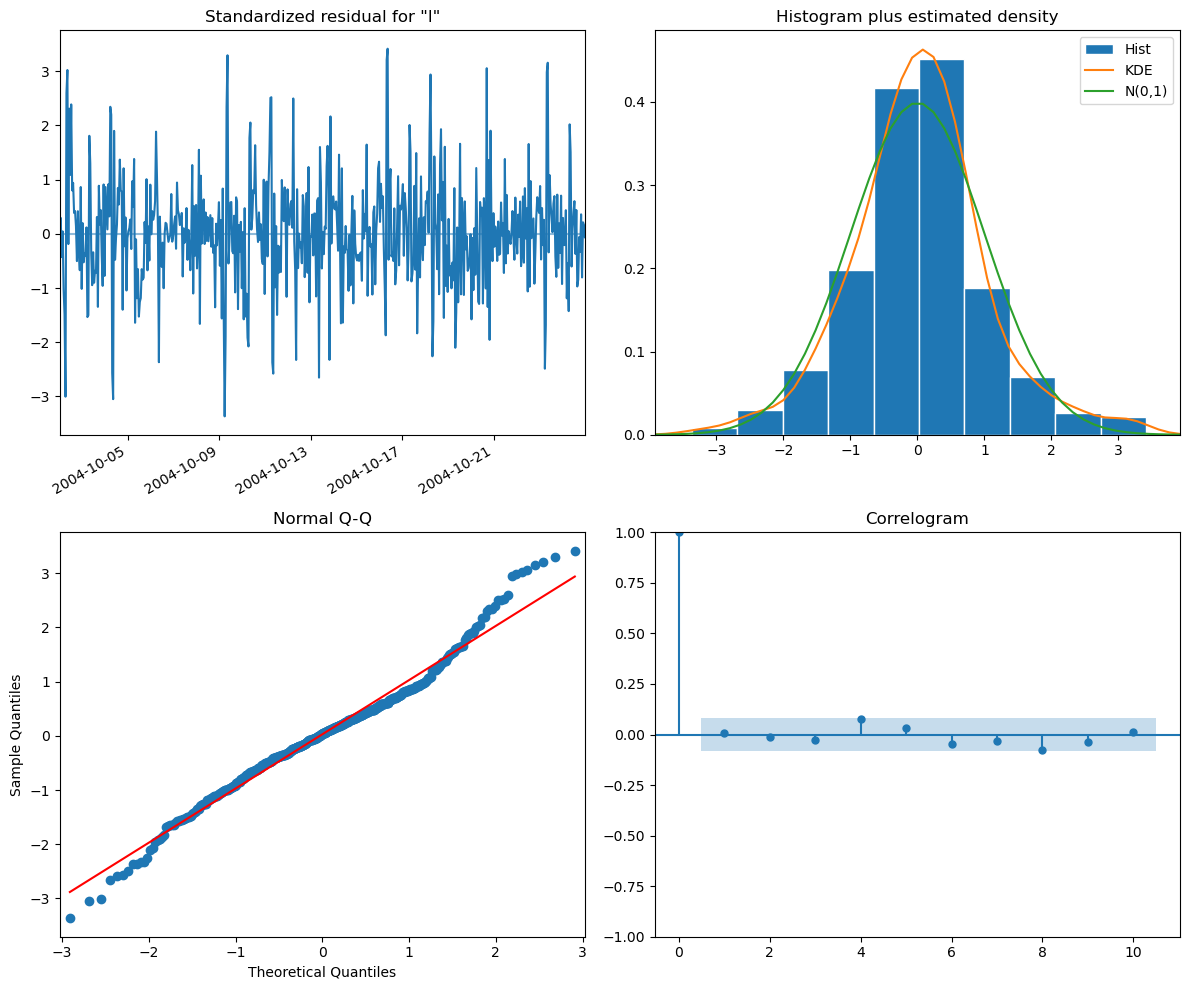

In [107]:
# Diagnostics: ARIMA(2,0,1)(2,1,0)[24] 

SARIMA_model = sm.tsa.statespace.SARIMAX(
        load_long_z1_oct04_train["log_load_rs"], 
        order=(2,0,1),  # non-seasonal with no differencing
        seasonal_order=(2,1,0,24) # seasonal differencing
        )

SARIMA_model_fit = SARIMA_model.fit(disp=False, maxiter=500)
SARIMA_model_fit.plot_diagnostics(figsize=(12,10))
plt.tight_layout()
plt.show()

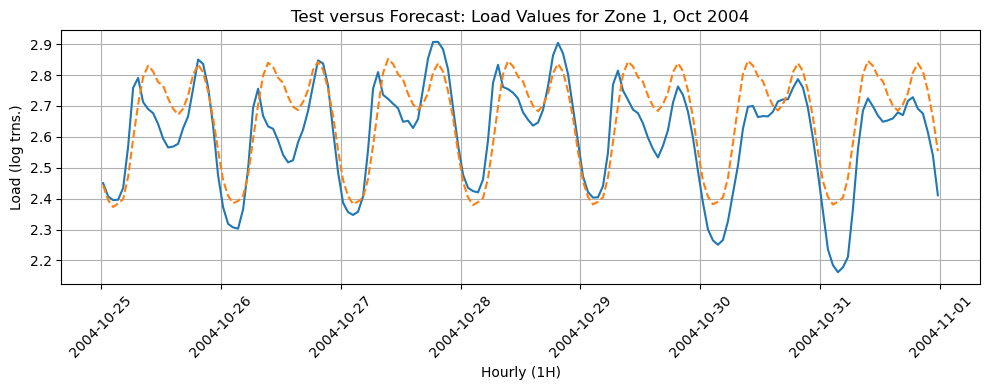

In [108]:
# Predicting 24*7 steps ahead
forecast_oct04 = SARIMA_model_fit.get_forecast(steps=24*7).predicted_mean

# Creating test data
load_long_z1_oct04_test = load_long_z1.loc[(load_long_z1.year == 2004) & (load_long_z1.month == 10),["timestamp","log_load_rs"]]
load_long_z1_oct04_test = load_long_z1_oct04_test.set_index("timestamp")
load_long_z1_oct04_test = load_long_z1_oct04_test['2004-10-25 00:30:00':]
load_long_z1_oct04_test.index = pd.to_datetime(load_long_z1_oct04_test.index)

# Fit on the test data

fig, ax = plt.subplots(figsize=(10, 4))
sns.lineplot(data=load_long_z1_oct04_test, x=load_long_z1_oct04_test.index, y=load_long_z1_oct04_test.log_load_rs, ax=ax)
sns.lineplot(forecast_oct04, linestyle = '--')
ax.set_title("Test versus Forecast: Load Values for Zone 1, Oct 2004")
ax.set_xlabel("Hourly (1H)")
ax.set_ylabel("Load (log trns.)")
ax.grid(True)
ax.tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()

In [109]:
# Performance on test set
print(f"R2 score: {r2_score(load_long_z1_oct04_test.log_load_rs, forecast_oct04)}")
print(f'RMSE score: {np.sqrt(mean_squared_error(load_long_z1_oct04_test.log_load_rs, forecast_oct04))}')
print(f'MAE score: {mean_absolute_error(load_long_z1_oct04_test.log_load_rs, forecast_oct04)}')
print(f'MAPE score: {mean_absolute_percentage_error(load_long_z1_oct04_test.log_load_rs, forecast_oct04)}')

R2 score: 0.5951796499909652
RMSE score: 0.10691649798009942
MAE score: 0.09052168867497329
MAPE score: 0.03518059746878117


Performance is worse than exponential smoothing.

##### Testing on Last Week of Dec 2004 (Zone 1)
Last week of Dec 2004 is used for testing. Multiple SARIMA models are evaluated and compared.

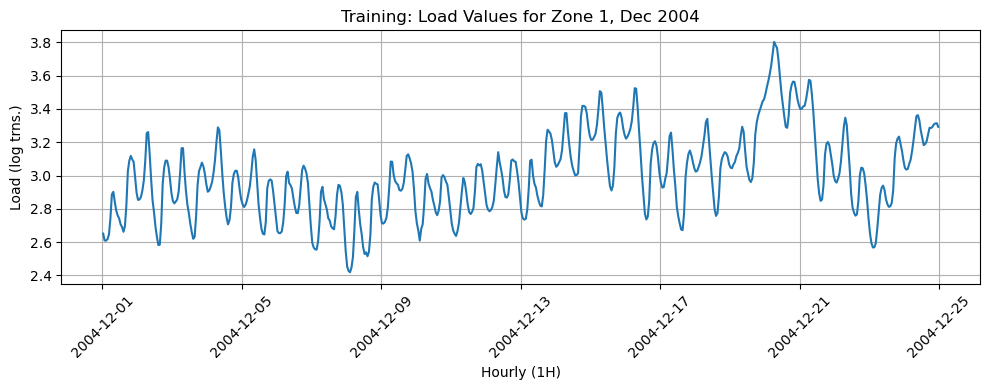

In [83]:
# Creating training data
load_long_z1_dec04_train = load_long_z1.loc[(load_long_z1.year == 2004) & (load_long_z1.month == 12),["timestamp","log_load_rs"]]
load_long_z1_dec04_train = load_long_z1_dec04_train.set_index("timestamp")
load_long_z1_dec04_train = load_long_z1_dec04_train[:'2004-12-24 23:30:00']
load_long_z1_dec04_train.index = pd.to_datetime(load_long_z1_dec04_train.index)

import seaborn as sns
fig, ax = plt.subplots(figsize=(10, 4))
sns.lineplot(data=load_long_z1_dec04_train, x=load_long_z1_dec04_train.index, y=load_long_z1_dec04_train.log_load_rs, ax=ax)
ax.set_title("Training: Load Values for Zone 1, Dec 2004")
ax.set_xlabel("Hourly (1H)")
ax.set_ylabel("Load (log trns.)")
ax.grid(True)
ax.tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()

In [84]:
# Comparing models - auto_arima

import pmdarima as pm
smodel_dec = pm.auto_arima(load_long_z1_dec04_train["log_load_rs"], start_p=0, start_q=0,test='adf',
                         max_p=2, max_q=1, m=24,
                         start_P=0, start_Q=0, max_P=4, max_Q=1, seasonal=True,
                         d=0, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=False)

 ARIMA(0,0,0)(0,1,0)[24] intercept   : AIC=-189.388, Time=0.19 sec
 ARIMA(0,0,0)(0,1,1)[24] intercept   : AIC=-217.530, Time=1.51 sec
 ARIMA(0,0,0)(1,1,0)[24] intercept   : AIC=-193.632, Time=0.98 sec
 ARIMA(0,0,0)(1,1,1)[24] intercept   : AIC=inf, Time=8.12 sec
 ARIMA(0,0,0)(2,1,0)[24] intercept   : AIC=-226.770, Time=3.42 sec
 ARIMA(0,0,0)(2,1,1)[24] intercept   : AIC=inf, Time=12.16 sec
 ARIMA(0,0,0)(3,1,0)[24] intercept   : AIC=inf, Time=9.51 sec
 ARIMA(0,0,0)(3,1,1)[24] intercept   : AIC=-400.032, Time=13.37 sec
 ARIMA(0,0,0)(4,1,0)[24] intercept   : AIC=inf, Time=19.47 sec
 ARIMA(0,0,0)(4,1,1)[24] intercept   : AIC=-406.676, Time=49.28 sec
 ARIMA(0,0,1)(0,1,0)[24] intercept   : AIC=-897.109, Time=1.98 sec
 ARIMA(0,0,1)(0,1,1)[24] intercept   : AIC=-921.883, Time=5.41 sec
 ARIMA(0,0,1)(1,1,0)[24] intercept   : AIC=-900.829, Time=7.23 sec
 ARIMA(0,0,1)(1,1,1)[24] intercept   : AIC=inf, Time=8.09 sec
 ARIMA(0,0,1)(2,1,0)[24] intercept   : AIC=-930.194, Time=8.25 sec
 ARIMA(0,0,1)(2,

C:\Users\singh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
C:\Users\singh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


-2335.594440921547


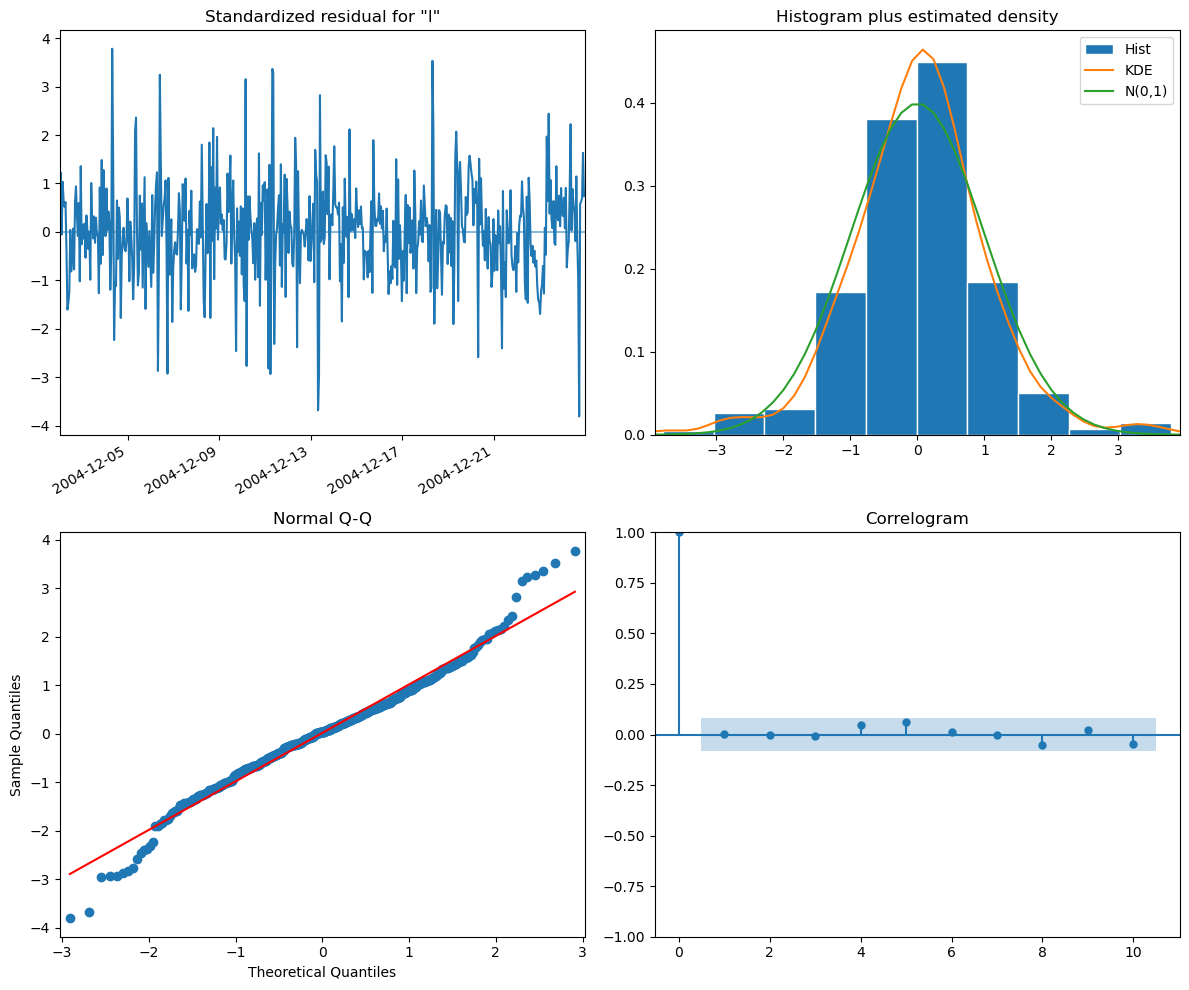

In [110]:
# Diagnostics: ARIMA(2,0,1)(2,1,0)[24]

SARIMA_model = sm.tsa.statespace.SARIMAX(
        load_long_z1_dec04_train["log_load_rs"], 
        order=(2,0,1),  # non-seasonal with no differencing
        seasonal_order=(2,1,0,24) # seasonal differencing
        )

SARIMA_model_fit = SARIMA_model.fit(disp=False, maxiter=500)
print(SARIMA_model_fit.aic)
SARIMA_model_fit.plot_diagnostics(figsize=(12,10))
plt.tight_layout()
plt.show()

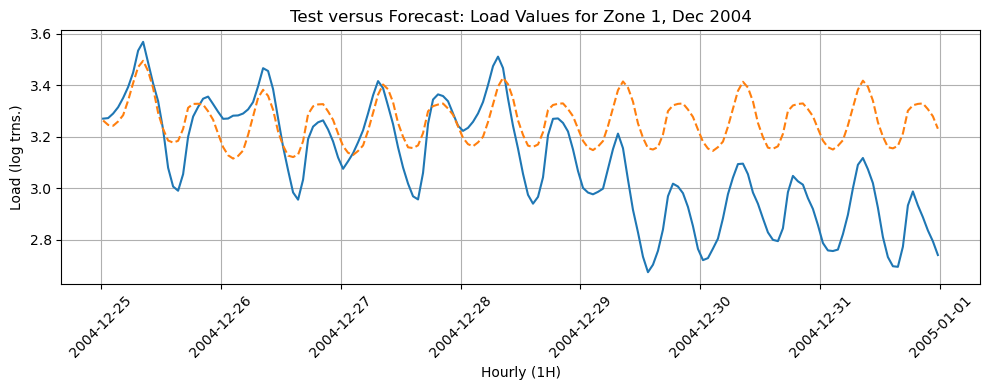

In [111]:
# Predicting 24*7 steps ahead
forecast_dec04 = SARIMA_model_fit.get_forecast(steps=24*7).predicted_mean

# Creating test data
load_long_z1_dec04_test = load_long_z1.loc[(load_long_z1.year == 2004) & (load_long_z1.month == 12),["timestamp","log_load_rs"]]
load_long_z1_dec04_test = load_long_z1_dec04_test.set_index("timestamp")
load_long_z1_dec04_test = load_long_z1_dec04_test['2004-12-25 00:30:00':]
load_long_z1_dec04_test.index = pd.to_datetime(load_long_z1_dec04_test.index)

# Fit on the test data

fig, ax = plt.subplots(figsize=(10, 4))
sns.lineplot(data=load_long_z1_dec04_test, x=load_long_z1_dec04_test.index, y=load_long_z1_dec04_test.log_load_rs, ax=ax)
sns.lineplot(forecast_dec04, linestyle = '--')
ax.set_title("Test versus Forecast: Load Values for Zone 1, Dec 2004")
ax.set_xlabel("Hourly (1H)")
ax.set_ylabel("Load (log trns.)")
ax.grid(True)
ax.tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()

In [112]:
# Performance on test set
print(f"R2 score: {r2_score(load_long_z1_dec04_test.log_load_rs, forecast_dec04)}")
print(f'RMSE score: {np.sqrt(mean_squared_error(load_long_z1_dec04_test.log_load_rs, forecast_dec04))}')
print(f'MAE score: {mean_absolute_error(load_long_z1_dec04_test.log_load_rs, forecast_dec04)}')
print(f'MAPE score: {mean_absolute_percentage_error(load_long_z1_dec04_test.log_load_rs, forecast_dec04)}')

R2 score: -0.29023068865270907
RMSE score: 0.24605338920619613
MAE score: 0.1979514730678583
MAPE score: 0.06712984882995265


Performance is better than ES